# Import libraries

In [ ]:
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
pd.set_option('display.precision', 4)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = [20, 5]
from tqdm import tqdm
from itertools import combinations
import copy
import re

# packages for data_preparation pipeline
import sklearn
sklearn.set_config(display='diagram')

import copy
from collections import Counter
import os
from datetime import datetime
from joblib import dump, load

# fuzzy match
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sparse_dot_topn import awesome_cossim_topn # https://pypi.org/project/sparse-dot-topn/
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# available: dist_abs, dist, sim
# dist_abs (<= length of word)= absolute distance
# dist (0 to 1) = relative to length of a word
# sim (0 to 1)= similarity = 1 - dist
import abydos.distance

# task 1 fuzzy match

# Import files

In [ ]:
nodes_df = pd.read_csv('../UofT_nodes.csv')
# CUSTOMER_ID = unique identifier id
nodes_df.CUSTOMER_ID = nodes_df.CUSTOMER_ID.astype(int).astype(str)

## UofT_nodes (customer features)

- BIRTH_DT (Date): date of birth
- CUST_ADD_DT (Date): date of joining the bank
- OCPTN_NM (int): occupation code -> occupation risk
- RES_CNTRY_CA (Bool): whether customer lives in Canada
- CNTRY_OF_INCOME_CA (Bool): whether customer receives income in Canada
- PEP_FL (Bool): whether person is PEP
- CASH_SUM_IN (float): sum of cash in LTM
- CASH_CNT_IN (int): count of cash in LTM
- CASH_SUM_OUT (float): sum of cash out LTM
- CASH_CNT_OUT (int): count of cash out LTM
- WIRES_SUM_IN (float): sum of wire in LTM
- WIRES_CNT_IN (int): count of wire in LTM
- WIRES_SUM_OUT (float): sum of wire out LTM
- WIRES_CNT_OUT (int): count of wire out LTM
- COUNTRY_RISK_INCOME (int): country of income risk rating
- COUNTRY_RISK_RESIDENCY (int): country of residency risk rating
- RISK (str, categorical): customer risk rating <font color='red'> (target) </font>
- NAME (str): name of customer
- Gender (bool): gender of customer
- CUSTOMER_ID (int): customer_id <font color='red'> (unique identifier) </font>

### Task 1: Name, BIRTH_DT, RES_CNTRY_CA, CNTRY_OF_INCOME_CA, PEP_FL, GENDER

In [ ]:
nodes_df

,BIRTH_DT,CUST_ADD_DT,OCPTN_NM,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,WIRES_CNT_OUT,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY,RISK,NAME,GENDER,CUSTOMER_ID
0,1981-09-01,2007-07-05,89.0000,1,1,0.0000,2577.7850,2.0000,2851.6630,7.0000,70774.0000,62.0000,24244.0000,35.0000,Low,Low,low,"Young, Marie Mildren Coleman",Female,935382
1,1994-02-21,2019-05-19,89.0000,1,1,0.0000,3035.5020,2.0000,4805.9970,15.0000,282929.0000,76.0000,196439.0000,152.0000,Low,Low,low,Mark Stupar Lecy,Male,2305
2,1962-11-16,2011-08-02,89.0000,1,1,0.0000,1617.5710,1.0000,3482.8090,11.0000,7632.0000,6.0000,33598.0000,20.0000,Low,Low,low,Dean Glasper Wendel Reeves,Male,472403
3,1998-06-20,2001-08-15,89.0000,1,1,0.0000,3587.0420,5.0000,1940.9430,8.0000,149253.0000,71.0000,105896.0000,238.0000,Low,Low,low,"Hulsey, Linda Rauth",Female,227994
4,1942-01-24,2012-10-28,89.0000,1,1,0.0000,1725.5240,2.0000,13197.1690,43.0000,92318.0000,96.0000,187403.0000,180.0000,Low,Low,low,Carolyn Washington Roberts,Female,418265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1939-01-16,1994-03-19,467.0000,0,1,0.0000,18945.1080,10.0000,32210.0000,21.0000,1186467.0000,25.0000,2550098.0000,174.0000,Low,High,high,Bret* Dove Gainey,Male,420884
999996,1970-12-13,1995-12-22,467.0000,0,1,0.0000,5775.6010,7.0000,5015.7410,15.0000,244504.0000,53.0000,417992.0000,337.0000,Low,Low,low,Anthony Ray Montano Gomez,Male,429418
999997,1958-09-09,2010-11-03,65.0000,0,1,0.0000,2351.2550,2.0000,15997.0000,19.0000,3024271.0000,68.0000,948981.0000,124.0000,Low,High,high,Bernadette Schofield Pace Mile,Female,731360
999998,1983-09-15,2013-01-30,231.0000,0,1,0.0000,27312.6130,8.0000,3399.0000,5.0000,943477.0000,9.0000,376429.0000,12.0000,Low,High,high,"Wasson, Russell Terrell",Male,837988


In [ ]:
nodes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   BIRTH_DT                1000000 non-null  object 
 1   CUST_ADD_DT             995822 non-null   object 
 2   OCPTN_NM                993616 non-null   float64
 3   RES_CNTRY_CA            1000000 non-null  int64  
 4   CNTRY_OF_INCOME_CA      1000000 non-null  int64  
 5   PEP_FL                  1000000 non-null  float64
 6   CASH_SUM_IN             1000000 non-null  float64
 7   CASH_CNT_IN             1000000 non-null  float64
 8   CASH_SUM_OUT            1000000 non-null  float64
 9   CASH_CNT_OUT            1000000 non-null  float64
 10  WIRES_SUM_IN            1000000 non-null  float64
 11  WIRES_CNT_IN            1000000 non-null  float64
 12  WIRES_SUM_OUT           1000000 non-null  float64
 13  WIRES_CNT_OUT           1000000 non-null  float64
 14  COU

In [ ]:
nodes_df[nodes_df.NAME.isna()]

,BIRTH_DT,CUST_ADD_DT,OCPTN_NM,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,WIRES_CNT_OUT,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY,RISK,NAME,GENDER,CUSTOMER_ID
666,1992-02-15,2010-11-12,89.0000,1,1,0.0000,4939.5810,6.0000,1028.5850,4.0000,7096.0000,2.0000,61067.0000,49.0000,Low,Low,low,NaN,Female,43461
1015,2009-05-14,2021-02-20,89.0000,1,1,0.0000,3556.2220,3.0000,338.1130,1.0000,38090.0000,15.0000,80053.0000,43.0000,Low,Low,low,NaN,NaN,518946
1199,1953-10-26,1986-03-24,89.0000,1,1,0.0000,10251.6130,17.0000,14416.1080,41.0000,172992.0000,80.0000,216597.0000,297.0000,Low,Low,low,NaN,NaN,402686
1252,1945-11-13,2010-06-28,NaN,1,1,0.0000,5844.4630,7.0000,11162.3850,18.0000,158864.0000,94.0000,91584.0000,72.0000,Low,Low,low,NaN,NaN,104453
2263,1977-04-22,2013-06-03,89.0000,1,1,0.0000,1442.5830,2.0000,3226.9400,13.0000,49338.0000,65.0000,12038.0000,35.0000,Low,Low,low,NaN,NaN,637208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993715,1987-07-17,2016-06-15,504.0000,0,1,1.0000,38391.0000,12.0000,35981.0000,10.0000,547714.0000,5.0000,1037825.0000,49.0000,Low,High,medium,NaN,NaN,896627
993864,1970-09-14,2011-01-21,89.0000,0,1,0.0000,31240.0000,22.0000,16938.0000,19.0000,16636259.0000,21.0000,5142265.0000,183.0000,Low,High,medium,NaN,NaN,600679
994480,1953-11-20,2019-09-24,79.0000,0,1,0.0000,8679.0000,5.0000,63174.0000,35.0000,6750058.0000,23.0000,2351034.0000,88.0000,Low,High,medium,NaN,NaN,731678
997708,1971-12-18,2014-09-01,89.0000,0,1,0.0000,62692.0000,25.0000,11552.0000,3.0000,4904771.0000,2.0000,2189384.0000,64.0000,Low,High,medium,NaN,NaN,691062


## Entities Open Sanctions
https://www.opensanctions.org/datasets/default/ 

In [ ]:
entities_df = pd.read_json(
    '../entities.ftm.json', 
    lines=True,
    # nrows = 100
    )
entities_df

,id,schema,properties,referents,datasets,first_seen,last_seen,caption,target
0,acf-00040861bc3f593000830d987d09967ef3503ef1,Person,"{'alias': ['Колыванов Егор'], 'position': ['Fe...",[],[ru_acf_bribetakers],2022-05-05T15:26:25,2023-02-14T12:09:52,Kolyvanov Egor,True
1,acf-0011c68a768924609dc5da5707ac7fa4c4d645a2,Person,"{'position': ['Warmongers', 'Athletes'], 'note...",[],[ru_acf_bribetakers],2022-07-09T18:14:08,2023-02-14T12:09:52,Shipov Sergei Yurievich,True
2,acf-001e7e4c0363f08f1e784c230457960b84a6416f,Person,{'position': ['Regional investigations subject...,[],[ru_acf_bribetakers],2022-05-05T15:26:25,2023-02-14T12:09:52,Egorov Ivan Mikhailovich,True
3,acf-002c208139012c8d93b6298358188d7cadafe648,Person,"{'alias': ['Гореславский Алексей Сергеевич'], ...",[],[ru_acf_bribetakers],2022-09-20T01:05:26,2023-02-14T12:09:52,Goreslavsky Alexey Sergeyevich,True
4,acf-002cc8fdf8fe41185091a7cb6c598663e7a22eb5,Person,"{'notes': ['Russian singer, composer. Supporte...",[],[ru_acf_bribetakers],2022-09-20T01:05:26,2023-02-14T12:09:52,Samoilova Natalya Vladimirovna,True
...,...,...,...,...,...,...,...,...,...
597560,zafic-fd8ee7423e921994c1b4b83cc639071a4ceb1b6a,Sanction,{'sourceUrl': ['https://www.fic.gov.za/Interna...,[],[za_fic_sanctions],2023-02-09T18:45:56,2023-02-14T12:38:15,Sanction,False
597561,zafic-fd95f884985cfbdadb03c495b32679482cb7c721,Sanction,"{'country': ['za'], 'entity': ['NK-hTnCKHq365A...",[],[za_fic_sanctions],2023-02-09T18:45:56,2023-02-14T12:38:15,Sanction,False
597562,zafic-fe8ff206eda946e3612996fe3df3a169879eac5e,Sanction,"{'unscId': ['TAi.096'], 'entity': ['Q6934100']...",[],[za_fic_sanctions],2023-02-09T18:45:56,2023-02-14T12:38:15,Sanction,False
597563,zafic-ff2adf65d2a3a6f796c6225c3b32c897b82fc2dc,Sanction,"{'country': ['za'], 'entity': ['Q342263'], 'un...",[],[za_fic_sanctions],2023-02-09T18:45:56,2023-02-14T12:38:15,Sanction,False


In [ ]:
# list of entities available (schema = Person)
sorted(entities_df.schema.unique())

['Address',
 'Airplane',
 'Associate',
 'Company',
 'CryptoWallet',
 'Directorship',
 'Employment',
 'Family',
 'Identification',
 'LegalEntity',
 'Membership',
 'Organization',
 'Ownership',
 'Passport',
 'Person',
 'Representation',
 'Sanction',
 'Security',
 'UnknownLink',
 'Vessel']

In [ ]:
# include both target and non-target related entities
entities_df.target.value_counts()

False    329074
True     268491
Name: target, dtype: int64

### Entities = Person

In [ ]:
# properties stored in nested json column
entities_person = entities_df[entities_df['schema'] == 'Person'].reset_index(drop=True)
entities_person

,id,schema,properties,referents,datasets,first_seen,last_seen,caption,target
0,acf-00040861bc3f593000830d987d09967ef3503ef1,Person,"{'alias': ['Колыванов Егор'], 'position': ['Fe...",[],[ru_acf_bribetakers],2022-05-05T15:26:25,2023-02-14T12:09:52,Kolyvanov Egor,True
1,acf-0011c68a768924609dc5da5707ac7fa4c4d645a2,Person,"{'position': ['Warmongers', 'Athletes'], 'note...",[],[ru_acf_bribetakers],2022-07-09T18:14:08,2023-02-14T12:09:52,Shipov Sergei Yurievich,True
2,acf-001e7e4c0363f08f1e784c230457960b84a6416f,Person,{'position': ['Regional investigations subject...,[],[ru_acf_bribetakers],2022-05-05T15:26:25,2023-02-14T12:09:52,Egorov Ivan Mikhailovich,True
3,acf-002c208139012c8d93b6298358188d7cadafe648,Person,"{'alias': ['Гореславский Алексей Сергеевич'], ...",[],[ru_acf_bribetakers],2022-09-20T01:05:26,2023-02-14T12:09:52,Goreslavsky Alexey Sergeyevich,True
4,acf-002cc8fdf8fe41185091a7cb6c598663e7a22eb5,Person,"{'notes': ['Russian singer, composer. Supporte...",[],[ru_acf_bribetakers],2022-09-20T01:05:26,2023-02-14T12:09:52,Samoilova Natalya Vladimirovna,True
...,...,...,...,...,...,...,...,...,...
258927,us-occ-fff06e619594bc67212688d8affc40e58bbbe4f8,Person,"{'lastName': ['Hinnenkamp'], 'name': ['Laurie ...",[],[us_occ_enfact],2022-07-12T12:01:58,2023-02-14T12:28:17,Laurie Hinnenkamp,True
258928,us-occ-fff7d010832a1f6c6ff326d427d1d7f225900d2b,Person,"{'lastName': ['White'], 'firstName': ['Rachel ...",[],[us_occ_enfact],2022-07-12T12:01:58,2023-02-14T12:28:17,Rachel A. White,True
258929,zafic-120-sad-bin-sad-muhammad-shariyan-al-kabi,Person,"{'birthDate': ['1972-02-15'], 'name': ['SAD BI...",[],[za_fic_sanctions],2023-02-09T18:45:56,2023-02-14T12:38:15,SAD BIN SAD MUHAMMAD SHARIYAN AL-KABI,True
258930,zafic-58-mahmoud-mohammad-ahmad-bahaziq,Person,{'notes': ['Mothers name: Masouma Abd al-Rahma...,[],[za_fic_sanctions],2023-02-09T18:45:56,2023-02-14T12:38:15,MAHMOUD MOHAMMAD AHMAD BAHAZIQ,True


In [ ]:
entities_person.columns

Index(['id', 'schema', 'properties', 'referents', 'datasets', 'first_seen',
       'last_seen', 'caption', 'target'],
      dtype='object')

In [ ]:
# output schema == Person to json file
# entities_person.to_json('entities_person.ftm.json')

In [ ]:
# all columns available in properties nested json
pd.json_normalize(entities_person.properties.values.tolist())

,alias,position,birthDate,gender,notes,name,topics,firstName,secondName,createdAt,modifiedAt,country,birthPlace,middleName,nationality,addressEntity,idNumber,lastName,passportNumber,fatherName,weakAlias,title,email,sourceUrl,phone,sector,website,keywords,deathDate,registrationNumber,legalForm,ethnicity,program,innCode,status,motherName,taxNumber,summary,ogrnCode,address,previousName,icijId,publisher,leiCode,education,wikidataId,religion
0,[Колыванов Егор],"[Federal media employees, Propagandists]",[1980-11-15],[male],"[Russian propagandist: host of news program ""S...",[Kolyvanov Egor],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[Шипов Сергей Юрьевич],"[Warmongers, Athletes]",[1966-04-17],[male],"[Russian chess player, grandmaster, chess coac...",[Shipov Sergei Yurievich],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[Егоров Иван Михайлович],[Regional investigations subjects],[1961-01-21],[male],[Deputy of the State Council of the Republic o...,[Egorov Ivan Mikhailovich],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[Гореславский Алексей Сергеевич],"[Propagandists, Organizers of political repres...",[1977-07-13],[male],[Russian journalist and media manager. Helped ...,[Goreslavsky Alexey Sergeyevich],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[Самойлова Наталья Владимировна],"[Celebrities, influencers and bloggers, Sellou...",[1987-06-24],[female],"[Russian singer, composer. Supported the actio...",[Samoilova Natalya Vladimirovna],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258927,NaN,NaN,NaN,NaN,NaN,[Laurie Hinnenkamp],[crime.fin],[Laurie],NaN,NaN,NaN,[us],NaN,NaN,NaN,[addr-75ab5a4ff3c7d73e14d6e556914fd39b36bc5c48],NaN,[Hinnenkamp],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258928,NaN,NaN,NaN,NaN,NaN,[Rachel A. White],[crime.fin],[Rachel A.],NaN,NaN,NaN,[us],NaN,NaN,NaN,[addr-8fe35b9009d4c265cc7c07268c83b4bf562b9c47],NaN,[White],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258929,NaN,NaN,[1972-02-15],NaN,[Qatar-based facilitator who provides financia...,[SAD BIN SAD MUHAMMAD SHARIYAN AL-KABI],[sanction],NaN,NaN,[2015-09-21],NaN,NaN,NaN,NaN,[qa],[NK-3nokyyrzUiPe6WKhc5XUJb],NaN,NaN,"[National Identification Number, 27263401275, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258930,NaN,NaN,[1956-07-07],NaN,[Mothers name: Masouma Abd al-Rahman. Photo av...,[MAHMOUD MOHAMMAD AHMAD BAHAZIQ],[sanction],NaN,NaN,[2006-12-07],NaN,NaN,"[Al-Sulaymaniyah Governorate, Iraq]",NaN,[iq],[addr-f7cd71d766a718f38c8a870daf9a810d519b4fd6],NaN,NaN,"[National Identification Number, 0075258]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
person_properties = pd.json_normalize(entities_person.properties)[
    ['name', 'alias', 'weakAlias', 'previousName', 'birthDate', 'gender', 'country', 'nationality'] # only pick these properties to unnest
    ].apply(lambda x: x.str[0]) # unlist every column
person_properties

,name,alias,weakAlias,previousName,birthDate,gender,country,nationality
0,Kolyvanov Egor,Колыванов Егор,NaN,NaN,1980-11-15,male,NaN,NaN
1,Shipov Sergei Yurievich,Шипов Сергей Юрьевич,NaN,NaN,1966-04-17,male,NaN,NaN
2,Egorov Ivan Mikhailovich,Егоров Иван Михайлович,NaN,NaN,1961-01-21,male,NaN,NaN
3,Goreslavsky Alexey Sergeyevich,Гореславский Алексей Сергеевич,NaN,NaN,1977-07-13,male,NaN,NaN
4,Samoilova Natalya Vladimirovna,Самойлова Наталья Владимировна,NaN,NaN,1987-06-24,female,NaN,NaN
...,...,...,...,...,...,...,...,...
258927,Laurie Hinnenkamp,NaN,NaN,NaN,NaN,NaN,us,NaN
258928,Rachel A. White,NaN,NaN,NaN,NaN,NaN,us,NaN
258929,SAD BIN SAD MUHAMMAD SHARIYAN AL-KABI,NaN,NaN,NaN,1972-02-15,NaN,NaN,qa
258930,MAHMOUD MOHAMMAD AHMAD BAHAZIQ,NaN,NaN,NaN,1956-07-07,NaN,NaN,iq


### Property details

In [ ]:
person_detailed = pd.concat([
    entities_person[['datasets']].apply(lambda x: x.str[0]), 
    entities_person[['id', 'target', 'caption']],
    person_properties
    ], axis=1)

person_detailed

,datasets,id,target,caption,name,alias,weakAlias,previousName,birthDate,gender,country,nationality
0,ru_acf_bribetakers,acf-00040861bc3f593000830d987d09967ef3503ef1,True,Kolyvanov Egor,Kolyvanov Egor,Колыванов Егор,NaN,NaN,1980-11-15,male,NaN,NaN
1,ru_acf_bribetakers,acf-0011c68a768924609dc5da5707ac7fa4c4d645a2,True,Shipov Sergei Yurievich,Shipov Sergei Yurievich,Шипов Сергей Юрьевич,NaN,NaN,1966-04-17,male,NaN,NaN
2,ru_acf_bribetakers,acf-001e7e4c0363f08f1e784c230457960b84a6416f,True,Egorov Ivan Mikhailovich,Egorov Ivan Mikhailovich,Егоров Иван Михайлович,NaN,NaN,1961-01-21,male,NaN,NaN
3,ru_acf_bribetakers,acf-002c208139012c8d93b6298358188d7cadafe648,True,Goreslavsky Alexey Sergeyevich,Goreslavsky Alexey Sergeyevich,Гореславский Алексей Сергеевич,NaN,NaN,1977-07-13,male,NaN,NaN
4,ru_acf_bribetakers,acf-002cc8fdf8fe41185091a7cb6c598663e7a22eb5,True,Samoilova Natalya Vladimirovna,Samoilova Natalya Vladimirovna,Самойлова Наталья Владимировна,NaN,NaN,1987-06-24,female,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
258927,us_occ_enfact,us-occ-fff06e619594bc67212688d8affc40e58bbbe4f8,True,Laurie Hinnenkamp,Laurie Hinnenkamp,NaN,NaN,NaN,NaN,NaN,us,NaN
258928,us_occ_enfact,us-occ-fff7d010832a1f6c6ff326d427d1d7f225900d2b,True,Rachel A. White,Rachel A. White,NaN,NaN,NaN,NaN,NaN,us,NaN
258929,za_fic_sanctions,zafic-120-sad-bin-sad-muhammad-shariyan-al-kabi,True,SAD BIN SAD MUHAMMAD SHARIYAN AL-KABI,SAD BIN SAD MUHAMMAD SHARIYAN AL-KABI,NaN,NaN,NaN,1972-02-15,NaN,NaN,qa
258930,za_fic_sanctions,zafic-58-mahmoud-mohammad-ahmad-bahaziq,True,MAHMOUD MOHAMMAD AHMAD BAHAZIQ,MAHMOUD MOHAMMAD AHMAD BAHAZIQ,NaN,NaN,NaN,1956-07-07,NaN,NaN,iq


In [ ]:
person_detailed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258932 entries, 0 to 258931
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   datasets      258932 non-null  object
 1   id            258932 non-null  object
 2   target        258932 non-null  bool  
 3   caption       258932 non-null  object
 4   name          257141 non-null  object
 5   alias         164411 non-null  object
 6   weakAlias     1515 non-null    object
 7   previousName  18 non-null      object
 8   birthDate     188128 non-null  object
 9   gender        185793 non-null  object
 10  country       152403 non-null  object
 11  nationality   205874 non-null  object
dtypes: bool(1), object(11)
memory usage: 22.0+ MB


#### drop NA rows

In [ ]:
# drop: no name for these records
# caption = Person
# name, alias, weakAlias, previousName = NA
person_detailed[(np.all(person_detailed[['name', 'alias', 'weakAlias', 'previousName']].isna(), axis=1)) & (person_detailed.caption == 'Person')]

,datasets,id,target,caption,name,alias,weakAlias,previousName,birthDate,gender,country,nationality
32086,interpol_red_notices,interpol-red-2015-80480,True,Person,NaN,NaN,NaN,NaN,1983-03-01,male,NaN,dz
51021,bg_omnio_poi,omnio-101ddd6da7429cfb629a4933b1ed3c7a6adcc2f3,True,Person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51036,bg_omnio_poi,omnio-275446253f0f789d852d64b4eea7df9fac649f61,True,Person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51058,bg_omnio_poi,omnio-4a669d56db95c35f1cfa5e6be6f02ed025a957ed,True,Person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51063,bg_omnio_poi,omnio-50558504862b857a26df792203ab269279b540f8,True,Person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
258895,us_occ_enfact,us-occ-ff180d1728beb96280b298ddd6e06de1391facf2,True,Person,NaN,NaN,NaN,NaN,NaN,NaN,us,NaN
258896,us_occ_enfact,us-occ-ff1de08827a29bff3a9ff5732bb12b8a62f1bd79,True,Person,NaN,NaN,NaN,NaN,NaN,NaN,us,NaN
258897,us_occ_enfact,us-occ-ff1edd5a6787b97614334fd385a43c5127f340e8,True,Person,NaN,NaN,NaN,NaN,NaN,NaN,us,NaN
258902,us_occ_enfact,us-occ-ff496bf3806a2bacbfa9c8121219daeb6d6ef734,True,Person,NaN,NaN,NaN,NaN,NaN,NaN,us,NaN


In [ ]:
# drop the above rows
person_detailed = person_detailed[~((np.all(person_detailed[['name', 'alias', 'weakAlias', 'previousName']].isna(), axis=1)) & (person_detailed.caption == 'Person'))]

#### careful of duplicated ids
- keep it for now as we don't know if the different format or extra information might help
- otherwise we can pick to keep first or last with groupby().first() or .last()

In [ ]:
# number of unique ids in these duplicated ids
person_detailed[person_detailed.id.duplicated(keep=False)].id.nunique()

94

In [ ]:
# duplicated ids
person_detailed[person_detailed.id.duplicated(keep=False)].sort_values('id')

,datasets,id,target,caption,name,alias,weakAlias,previousName,birthDate,gender,country,nationality
56549,wikidata,Q106988954,False,Manuel Zerillo Bazalar,Manuel Zerillo Bazalar,Manuel Salvador Zerillo Bazalar,NaN,NaN,1951-12-28,male,NaN,pe
58711,everypolitician,Q106988954,True,Manuel Salvador Zerillo Bazalar,Manuel Salvador Zerillo Bazalar,Zerillo Bazalar Manuel Salvador,NaN,NaN,NaN,male,NaN,pe
55387,wikidata,Q111291907,True,Joel Matiza,Joel Matiza,Joel Biggie Matiza,NaN,NaN,1960-08-17,male,zw,zw
67557,ca_dfatd_sema_sanctions,Q111291907,True,Biggie J. Matiza,Biggie J. Matiza,"Matiza, Biggie J.",NaN,NaN,1960-08-17,male,zw,zw
67757,everypolitician,Q111313831,True,Dzikamai Calisto Mavhaire,Dzikamai Calisto Mavhaire,"Mavhaire, Dzikamai Calisto",NaN,NaN,NaN,male,NaN,zw
...,...,...,...,...,...,...,...,...,...,...,...,...
213682,everypolitician,Q9131042,True,Nyamaagiin Enkhbold,Nyamaagiin Enkhbold,ENKHBOLD Nyamaa,NaN,NaN,1957-01-06,male,NaN,mn
161546,wikidata,Q9190484,True,D. O. Chaoke,D. O. Chaoke,朝克,NaN,NaN,1957,male,cn,cn
214288,everypolitician,Q9190484,True,朝克,朝克,NaN,NaN,NaN,1957,male,NaN,cn
209047,wikidata,Q9203344,True,Zhu Haowen,Zhu Haowen,朱浩文,NaN,NaN,1967-02,male,cn,cn


In [ ]:
# inner merge on id will return both records
pd.DataFrame([{'id': 'Q106988954'}]).merge(person_detailed[person_detailed.id.duplicated(keep=False)].sort_values('id'),
                                           how = 'inner',
                                           on = 'id')

,id,datasets,target,caption,name,alias,weakAlias,previousName,birthDate,gender,country,nationality
0,Q106988954,wikidata,False,Manuel Zerillo Bazalar,Manuel Zerillo Bazalar,Manuel Salvador Zerillo Bazalar,NaN,NaN,1951-12-28,male,NaN,pe
1,Q106988954,everypolitician,True,Manuel Salvador Zerillo Bazalar,Manuel Salvador Zerillo Bazalar,Zerillo Bazalar Manuel Salvador,NaN,NaN,NaN,male,NaN,pe


### output and load person_detailed

In [ ]:
person_detailed.to_csv('person_detailed.csv', index=False)

In [ ]:
person_detailed = pd.read_csv('person_detailed.csv')
person_detailed

C:\Users\WilliamKwok\AppData\Local\Temp\ipykernel_24628\3898230091.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  person_detailed = pd.read_csv('person_detailed.csv')


,datasets,id,target,caption,name,alias,weakAlias,previousName,birthDate,gender,country,nationality
0,ru_acf_bribetakers,acf-00040861bc3f593000830d987d09967ef3503ef1,True,Kolyvanov Egor,Kolyvanov Egor,Колыванов Егор,NaN,NaN,1980-11-15,male,NaN,NaN
1,ru_acf_bribetakers,acf-0011c68a768924609dc5da5707ac7fa4c4d645a2,True,Shipov Sergei Yurievich,Shipov Sergei Yurievich,Шипов Сергей Юрьевич,NaN,NaN,1966-04-17,male,NaN,NaN
2,ru_acf_bribetakers,acf-001e7e4c0363f08f1e784c230457960b84a6416f,True,Egorov Ivan Mikhailovich,Egorov Ivan Mikhailovich,Егоров Иван Михайлович,NaN,NaN,1961-01-21,male,NaN,NaN
3,ru_acf_bribetakers,acf-002c208139012c8d93b6298358188d7cadafe648,True,Goreslavsky Alexey Sergeyevich,Goreslavsky Alexey Sergeyevich,Гореславский Алексей Сергеевич,NaN,NaN,1977-07-13,male,NaN,NaN
4,ru_acf_bribetakers,acf-002cc8fdf8fe41185091a7cb6c598663e7a22eb5,True,Samoilova Natalya Vladimirovna,Samoilova Natalya Vladimirovna,Самойлова Наталья Владимировна,NaN,NaN,1987-06-24,female,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
257158,us_occ_enfact,us-occ-fff06e619594bc67212688d8affc40e58bbbe4f8,True,Laurie Hinnenkamp,Laurie Hinnenkamp,NaN,NaN,NaN,NaN,NaN,us,NaN
257159,us_occ_enfact,us-occ-fff7d010832a1f6c6ff326d427d1d7f225900d2b,True,Rachel A. White,Rachel A. White,NaN,NaN,NaN,NaN,NaN,us,NaN
257160,za_fic_sanctions,zafic-120-sad-bin-sad-muhammad-shariyan-al-kabi,True,SAD BIN SAD MUHAMMAD SHARIYAN AL-KABI,SAD BIN SAD MUHAMMAD SHARIYAN AL-KABI,NaN,NaN,NaN,1972-02-15,NaN,NaN,qa
257161,za_fic_sanctions,zafic-58-mahmoud-mohammad-ahmad-bahaziq,True,MAHMOUD MOHAMMAD AHMAD BAHAZIQ,MAHMOUD MOHAMMAD AHMAD BAHAZIQ,NaN,NaN,NaN,1956-07-07,NaN,NaN,iq


In [ ]:
# number of datasets
person_detailed.datasets.nunique()

56

In [ ]:
# output
# entities_df.iloc[:(entities_df.shape[0]//3)].to_json('entities.ftm1.json')
# entities_df.iloc[(entities_df.shape[0]//3):(entities_df.shape[0]//3*2)].to_json('entities.ftm2.json')
# entities_df.iloc[(entities_df.shape[0]//3*2):].to_json('entities.ftm3.json')

# Fuzzy name matching logic
- Common errors
  - typing error
  - custom abbreviation
  - nicknames and alias
  - shuffling of first and last name
- Common questions
  - How many characters need to match?
  - What if the letters are the same but not in the same order?
  - What if there are extra letters?
  - Are some letters more important than others?
- 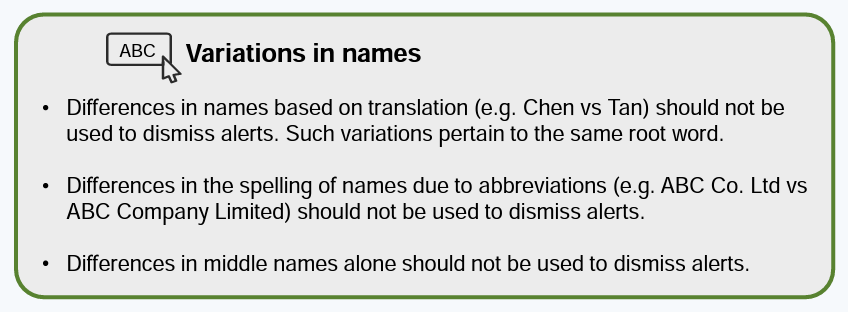

## fix format in customer names (space as delimiter)

In [ ]:
# characters that are unable to be decoded with utf-8
re.findall(r"[^ a-zA-Z]+", 'Егоров Иван Михайлович')

['Егоров', 'Иван', 'Михайлович']

In [ ]:
# all the non-characters in customer names are only symbols but not characters that are unable to be decoded with utf-8
np.array(sorted(set([y for x in [re.findall(r"[^ a-zA-Z]+", string) for string in nodes_df['NAME'].dropna().unique()] for y in x]), key = len))

array(['~', '<', '3', '>', ',', '"', '?', '7', '$', '9', '1', '{', '(',
       '\n', '/', ':', '_', '4', "'", '.', '`', '#', '\t', '&', '}', '^',
       '%', '!', ']', '\r', '=', '*', '-', '\x0b', '0', '|', '6', '+',
       '@', ';', '[', '5', '2', '\x0c', '\\', ')', '8', '7\x0c', '~6',
       '/~', '(|', '][', '{"', '**', "'9", "'4", '<\n', '0)', '7\n', '1|',
       '<5', '?,', '4&', '#3', '\x0c|', ',,', '~{', '8,', '.#', '&.',
       '$$', "$'", ']:', '&$', '\\[', "?'", '-(', '(?', ',"', '~|', '>{',
       '16', '[4', '2&', ':5', ';|', ".'", ']/', ')#', ']$', '=:', '\\{',
       '\t`', '=_', '#^', ',2', '41', '0^', '>|', '(7', '[]', '#{',
       '\\\t', ';;', '.3', '"\x0b', '9`', '}>', '>@', '\x0c<', '%;', '=-',
       '\x0b\x0b', ',&', '4\x0c', '*,', '0!', '9(', '\x0b.', ';\x0b',
       '9>', '#,', '\\=', '1\\', '|)', '$~', '0/', '7{', '];', '\n"',
       '%8', '")', '++', '#9', ']?', '4`', ':>', '@-', '5^', '/[', '\\\\',
       "#'", '*;', ':@', '*|', '*]', '\x0c?', ':$', '-5', '5#

In [ ]:
def format_func(string):
      # remove all non-english characters
      # no symbols allowed: no assumption in delimiter being space or underscore or hyphen
      # lower case
      return ' '.join(re.sub(r"[^a-zA-Z]+", "", string).split()).lower()

def phonetic_encode(phonetic_func, string):
    try:
        return ' '.join([x if type(x) is not tuple else x[0] for x in [phonetic_func(word) for word in format_func(string).split()]])
    except:
        print(f'error at {phonetic_func, string}')

## *implementation trick for large data = [vector space model](https://en.wikipedia.org/wiki/Vector_space_model)
- checking similarity across all pairs might be infeasible
- most have low similarity and few characters in common
- alternative methods
  - prefix matching
    - only look for words start with 'dav' if you want to match 'David'
  - n-gram matching (more robust)
    - only look for words with 'dav', 'avi', 'vid' to match 'David'
    - rank the highest matches
  - use a subset to filter for possible match before checking similarity 
    - e.g. check if first name or last name in full name
  - create index to search
    - annoy with word embedding

### 430 billion combinations

In [ ]:
# scotiabank customers
  # allowed duplicates: NAME
  # disallowed duplicates: CUSTOMER_ID
customer_selected = nodes_df[['CUSTOMER_ID', 'NAME']].dropna(subset = ['NAME'])
customer_ids = customer_selected.CUSTOMER_ID.values.tolist()
customer_names = customer_selected.NAME.values.tolist()

# target/non-target person
  # allowed duplicates: 
    # target_name (same name but different id could represent different people, e.g. different dob)
    # or 
    # id (same id from different name can come from same row but with different values of caption, name, alias, weakAlias, previousName etc.)
  # disallowed duplicates: combination of target_name and id
target_selected = pd.concat([
    # drop na separately on caption + name + alias + weakAlias + previousName
    person_detailed[['id', 'caption']].dropna(subset = ['caption']).rename(columns = {'caption': 'target_name'}),
    person_detailed[['id', 'name']].dropna(subset = ['name']).rename(columns = {'name': 'target_name'}),
    person_detailed[['id', 'alias']].dropna(subset = ['alias']).rename(columns = {'alias': 'target_name'}),
    person_detailed[['id', 'weakAlias']].dropna(subset = ['weakAlias']).rename(columns = {'weakAlias': 'target_name'}),
    person_detailed[['id', 'previousName']].dropna(subset = ['previousName']).rename(columns = {'previousName': 'target_name'}),
    ], axis = 0).\
    drop_duplicates() # drop duplicates on combination of target_name and id

target_ids = target_selected.id.values.tolist()
target_names = target_selected.target_name.values.tolist()

# a list of unique customer names and unique target/non-target names
all_names = customer_names + target_names

In [ ]:
print(f'{len(customer_names):,.0f} customers * {len(target_names):,.0f} targets = {len(customer_names) * len(target_names):,.0f} combinations')

999,340 customers * 430,728 targets = 430,443,719,520 combinations


## n-gram tokenization (2-gram: 42min, 3-gram: 9min)
- formatting issues are already taken into account by format_func
  - punctuation: 'Young Marie Mildren'
  - space: '       Young, Marie         Mildren            Coleman     '
  - case: 'yoUng maRie milDren colEmAn'

- Different types of mistakes to be taken by n-gram
  - ('no_space', 'Young, Marie Mildren', 'Young MarieMildren'),
  - ('abbrev', 'Young, Marie Mildren', 'Young M Mildren'),
  - ('extra_letter', 'Young, Marie Mildren', 'Young, Maarrie Mildren'),
  - ('extra_word', 'Young, Marie Mildren', 'Young, Mildren'),
  - ('letter_order', 'Young, Marie Mildren', 'Young, aMrei Mildren'),
  - ('word_order', 'Young, Marie Mildren', 'Marie Mildren Young'),
  - ('phonetic', 'Young, Marie Mildren', 'Yung Mary Mildren'),

In [ ]:
word_length = pd.Series([len(word) for name in all_names for word in format_func(name).split(' ')])

In [ ]:
word_length.describe(percentiles=[.05, .25, .5])

count   1430068.0000
mean         17.9776
std           7.4828
min           0.0000
5%            0.0000
25%          14.0000
50%          19.0000
max         142.0000
dtype: float64

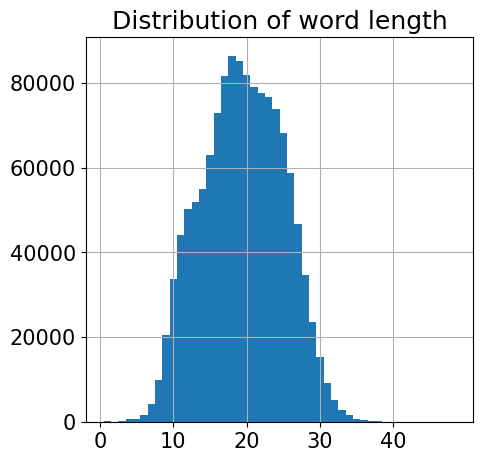

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
word_length.hist(bins = np.arange(1,50,1), align = 'left', ax = ax)
ax.set_xticks(ticks=np.arange(0,50,10))
ax.set_title('Distribution of word length')
plt.show()

### table for visualization

In [ ]:
# check tokenizer works as expected with formatting issue

abcd = TfidfVectorizer(
    binary = True, # binary occurrence: very short texts are likely to have noisy tf–idf values while the binary occurrence info is more stable.
    use_idf = False, 
    # token_pattern=r'(?u)\b\w+\b',
    ngram_range=(3,3), # 3-gram
    analyzer='char', # character as a token
    norm = None, # don't normalize to just show 1 and 0
    preprocessor = format_func
    )

examples_vector = [
    # formatting issues are already taken into account by format_func
    # punctuation: 'Young Marie Mildren'
    # space: '       Young, Marie         Mildren            Coleman     '
    # case: 'yoUng maRie milDren colEmAn'
    
    # positive cases with different types of mistakes
    # Exact match
    'Young, Marie Mildren',
    # no space
    'Young MarieMildren',
    # abbrev
    'Young M Mildren',
    # 'extra_letter'
    'Young, Maarrie Mildren',
    # 'extra_word'
    'Young, Mildren',
    # 'letter_order'
    'Young, aMrei Mildren',
    # 'word_order'
    'Marie Mildren Young',
    # 'phonetic'
    'Yung Mary Mildren',
    # wrong
    'Arei mr Remi'

]

examples_vector2 = [
  'Exact match',
  'No space',
  'Abbreviation',
  'Extra letter',
  'Extra word',
  'Typo',
  'Word order',
  'Phonetic',
  'Wrong person'
]

abcd.fit(examples_vector)

vector_representation = abcd.transform(examples_vector).todense()

def ngram_condition(v):
    if v == 0:
        return "-"
    else:
        return f"{v:0.0f}"

def cosine_condition(v):
    return f"{v:0.4f}"

def make_pretty(styler, subset = None):
    # styler.set_caption("2-grams")
    styler.format(ngram_condition, subset = subset)
    styler.format(cosine_condition, subset = ['Cosine Similarity'])
    styler.set_properties(**{'min-width': '20px', 'max-width': '80px', 'font-size': '10pt', 'text-align': 'center'})
    # styler.background()
    # styler.format_index(lambda v: v.strftime("%A"))
    styler.background_gradient(axis=None, vmin=vector_representation[vector_representation > 0].min(), vmax=vector_representation.max(), cmap="autumn", subset = subset)
    styler.set_properties(**{'font-weight': 'bold'}, subset = ['Cosine Similarity'])
    styler.text_gradient(cmap = 'Reds', subset = ['Cosine Similarity'])
    return styler

def style_zero(v, props=''):
    return props if v == 0 else None

def style_cosine(styler, subset = None):
    styler.format(ngram_condition, subset = subset)
    return styler

n_gram_df = pd.DataFrame(vector_representation, index=[examples_vector2, examples_vector], columns=abcd.get_feature_names_out())
n_gram_df.index.rename(('Variations', 'Examples'), inplace=True)
n_gram_df['Cosine Similarity'] = cosine_similarity(vector_representation)[0, :]
n_gram_df = n_gram_df.sort_values('Cosine Similarity', ascending=False)
slice_ = n_gram_df.drop(columns = ['Cosine Similarity']).columns
n_gram_df.\
style.pipe(make_pretty, subset = slice_).\
applymap(style_zero, props='background-color:white;color:white').\
set_table_styles({
    ('Cosine Similarity'): [{'selector': 'th', 'props': 'border-left: 1px solid #000066'},
                               {'selector': 'td', 'props': 'border-left: 1px solid #000066'}],
    ('aa'): [{'selector': 'th', 'props': 'border-left: 1px solid #000066'},
                               {'selector': 'td', 'props': 'border-left: 1px solid #000066'}],
}, overwrite=False, axis=0).\
set_table_styles([
    {'selector': 'th.row_heading', 'props': 'text-align: left;font-weight: normal;font-family: Helvetica; padding: 0em 3px; min-width: 70px'},
    {'selector': 'th.index_name', 'props': 'text-align: left;color: #E30F1C'},
    {'selector': 'td', 'props': 'padding: 0em 2px; min-height: 5px; min-width: 20px'},
], overwrite=False).\
set_table_styles({
    ('Exact match', 'Young, Marie Mildren'): [{'selector': 'th', 'props': 'font-weight: bold;background-color: #E30F1C;color: white'},{'selector': 'td.col28', 'props': 'font-weight: bold;background-color: #E30F1C;color: white'}],
    ('Wrong person', 'Arei mr Remi'): [{'selector': 'th', 'props': 'background-color: #333333;font-weight: bold;color: white'},{'selector': 'td.col40', 'props': 'background-color: #333333;font-weight: bold;color: white'}],
}, overwrite=False, axis=1)



C:\Users\WilliamKwok\anaconda3\envs\py9\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


,,aar,amr,are,ari,arr,ary,dre,eim,emi,eny,gam,gma,gmi,gmm,iem,ild,imi,imr,ldr,maa,mar,mil,mmi,mre,mrr,nga,ngm,nyo,oun,rei,rem,ren,rie,rre,rri,rym,ung,ymi,you,yun,Cosine Similarity
Variations,Examples,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Exact match,"Young, Marie Mildren",-,-,-,1,-,-,1,-,1,-,-,1,-,-,1,1,-,-,1,-,1,1,-,-,-,-,1,-,1,-,-,1,1,-,-,-,1,-,1,-,1.0000
No space,Young MarieMildren,-,-,-,1,-,-,1,-,1,-,-,1,-,-,1,1,-,-,1,-,1,1,-,-,-,-,1,-,1,-,-,1,1,-,-,-,1,-,1,-,1.0000
Word order,Marie Mildren Young,-,-,-,1,-,-,1,-,1,1,-,-,-,-,1,1,-,-,1,-,1,1,-,-,-,-,-,1,1,-,-,1,1,-,-,-,1,-,1,-,0.8667
Extra letter,"Young, Maarrie Mildren",1,-,-,-,1,-,1,-,1,-,-,1,-,-,1,1,-,-,1,1,-,1,-,-,-,-,1,-,1,-,-,1,1,-,1,-,1,-,1,-,0.8141
Extra word,"Young, Mildren",-,-,-,-,-,-,1,-,-,-,-,-,1,-,-,1,-,-,1,-,-,1,-,-,-,-,1,-,1,-,-,1,-,-,-,-,1,-,1,-,0.7348
Abbreviation,Young M Mildren,-,-,-,-,-,-,1,-,-,-,-,-,-,1,-,1,-,-,1,-,-,1,1,-,-,-,1,-,1,-,-,1,-,-,-,-,1,-,1,-,0.7006
Phonetic,Yung Mary Mildren,-,-,-,-,-,1,1,-,-,-,-,1,-,-,-,1,-,-,1,-,1,1,-,-,-,-,1,-,-,-,-,1,-,-,-,1,1,1,-,1,0.6445
Typo,"Young, aMrei Mildren",-,1,-,-,-,-,1,1,-,-,1,-,-,-,-,1,1,-,1,-,-,1,-,1,-,1,-,-,1,1,-,1,-,-,-,-,1,-,1,-,0.5333
Wrong person,Arei mr Remi,-,-,1,-,-,-,-,1,1,-,-,-,-,-,-,-,-,1,-,-,-,-,-,-,1,-,-,-,-,1,1,-,-,1,-,-,-,-,-,-,0.0913


### CSR sparse cosine similarity

In [ ]:
# check tokenizer works as expected with formatting issue

test_vectorizer = TfidfVectorizer(
    binary = True, # binary occurrence: very short texts are likely to have noisy tf–idf values while the binary occurrence info is more stable.
    use_idf = False, 
    # token_pattern=r'(?u)\b\w+\b',
    ngram_range=(3,3), # 3-gram
    analyzer='char', # character as a token
    norm = 'l2', # normalized so it's easier to compute cosine similarity
    preprocessor = format_func 
    )

test_vectorizer.fit([
    # punctuation in between words
    'Young,! M!arie Mildren !Coleman', 
    # extra spaces: 
    '       Young, Marie    Z Y     Mildren            Coleman     ', 
    # different cases: 
    'yoUng maRie milDren colEmAn'])

print(f'tokens = {test_vectorizer.get_feature_names_out()}')
vector_representation = test_vectorizer.transform(['Young Coleman Coleman', 'Coleman Young Coleman']).todense()
print(vector_representation)
cosine_similarity(vector_representation)

tokens = ['ari' 'col' 'dre' 'ema' 'emi' 'enc' 'ezy' 'gma' 'iem' 'iez' 'ild' 'ldr'
 'lem' 'man' 'mar' 'mil' 'nco' 'ngm' 'ole' 'oun' 'ren' 'rie' 'ung' 'ymi'
 'you' 'zym']
[[0.         0.33333333 0.         0.33333333 0.         0.
  0.         0.         0.         0.         0.         0.
  0.33333333 0.33333333 0.         0.         0.33333333 0.
  0.33333333 0.33333333 0.         0.         0.33333333 0.
  0.33333333 0.        ]
 [0.         0.35355339 0.         0.35355339 0.         0.
  0.         0.         0.         0.         0.         0.
  0.35355339 0.35355339 0.         0.         0.         0.
  0.35355339 0.35355339 0.         0.         0.35355339 0.
  0.35355339 0.        ]]


C:\Users\WilliamKwok\anaconda3\envs\py9\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array([[1.        , 0.94280904],
       [0.94280904, 1.        ]])

In [ ]:
test_vectorizer.fit(all_names)
tf_idf_customer = test_vectorizer.transform(customer_names)
tf_idf_target = test_vectorizer.transform(target_names)

In [ ]:
test_a = test_vectorizer.transform(['Young Coleman', 'Barry Chan', 'Quin Xavier'])
test_b = test_vectorizer.transform(['Young Coleman', 'Oreilly Book'])
sklearn_matches = cosine_similarity(test_a, test_b)
# faster option
csr_matches = awesome_cossim_topn(test_a, test_b.T, 100, 0)
# check both are the same
assert np.allclose(sklearn_matches, csr_matches.todense())

In [ ]:
# https://www.sun-analytics.nl/posts/2017-07-26-boosting-selection-of-most-similar-entities-in-large-scale-datasets/
matches = awesome_cossim_topn(A = tf_idf_customer, 
                              B = tf_idf_target.T, 
                              ntop = 10_000, # number of highest matches for each customer: higher for better accuracy but also more computing resources needed
                              lower_bound = 0.5, # lower bound for cosine similarity
                              n_jobs = -1)

In [ ]:
matches.nonzero()[0].size

5377024

In [ ]:
# https://bergvca.github.io/2017/10/14/super-fast-string-matching.html
def get_matches_df(sparse_matrix, left_id_vector, left_name_vector, right_id_vector, right_name_vector, top=None):
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
      nr_matches = top
    else:
      nr_matches = sparsecols.size
    
    left_id = np.empty([nr_matches], dtype=object)
    left_side = np.empty([nr_matches], dtype=object)
    right_id = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    similarity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
      left_id[index] = left_id_vector[sparserows[index]]
      left_side[index] = left_name_vector[sparserows[index]]
      right_id[index] = right_id_vector[sparsecols[index]]
      right_side[index] = right_name_vector[sparsecols[index]]
      similarity[index] = sparse_matrix.data[index]
    
    output = pd.DataFrame({
        'customer_id': left_id,
        'customer_side': left_side,
        'target_id': right_id,
        'target_side': right_side,
        'similarity': similarity})
    
    
    return output.sort_values('similarity', ascending=False)

In [ ]:
matches_df = get_matches_df(matches, 
                            customer_ids, customer_names, 
                            target_ids, target_names, 
                            top = None)
matches_df

,customer_id,customer_side,target_id,target_side,similarity
1593155,487705,John Stevens,Q1236990,John Stevens,1.0000
982849,960001,Jennifer Knight,Q104046574,Jennifer Knight,1.0000
4124602,2189,Paula Miller,Q7154730,Paula Miller,1.0000
5334731,72076,Robert Williams,Q111322463,Robert Williams,1.0000
3266055,823262,Paul Sanders,Q19360631,Paul Sanders,1.0000
...,...,...,...,...,...
1721165,359868,G\teorg,Q669384,Georgi Atanasov,0.5000
1721166,359868,G\teorg,Q12276470,Georgi Yordanov,0.5000
1721167,359868,G\teorg,Q7612638,Steve Georganas,0.5000
1721168,359868,G\teorg,Q120013,Georges Theiler,0.5000


In [ ]:
matches_df.to_pickle('matches_df.pkl')

In [ ]:
matches_df = pd.read_pickle('matches_df.pkl')
matches_df.customer_id = matches_df.customer_id.astype(str)
matches_df.rename(columns={'similarity': 'cosine_similarity'}, inplace=True)
matches_df

,customer_id,customer_side,target_id,target_side,cosine_similarity
1593155,487705,John Stevens,Q1236990,John Stevens,1.0000
982849,960001,Jennifer Knight,Q104046574,Jennifer Knight,1.0000
4124602,2189,Paula Miller,Q7154730,Paula Miller,1.0000
5334731,72076,Robert Williams,Q111322463,Robert Williams,1.0000
3266055,823262,Paul Sanders,Q19360631,Paul Sanders,1.0000
...,...,...,...,...,...
1721165,359868,G\teorg,Q669384,Georgi Atanasov,0.5000
1721166,359868,G\teorg,Q12276470,Georgi Yordanov,0.5000
1721167,359868,G\teorg,Q7612638,Steve Georganas,0.5000
1721168,359868,G\teorg,Q120013,Georges Theiler,0.5000


#### Alternative: define positive and negative examples to check
- cosine similarity works well with whole-word match
  - % of words matched
  - ordering 
  - extra word or missing word
- fuzzy algorithm should specialize for examples where cosine similarity won't work
  - given same cosine similarity, how to rank the differences?

In [ ]:
# examples = [
#     # formatting issues are already taken into account by format_func
#     # punctuation: 'Young Marie Mildren'
#     # space: '       Young, Marie         Mildren            Coleman     '
#     # case: 'yoUng maRie milDren colEmAn'
    
#     # positive cases with different types of mistakes
#     ('no_space', 'Young, Marie Mildren', 'Young MarieMildren'),
#     ('abbrev', 'Young, Marie Mildren', 'Young M Mildren'),
#     ('extra_letter', 'Young, Marie Mildren', 'Young, Maarrie Mildren'),
#     ('extra_word', 'Young, Marie Mildren', 'Young, Mildren'),
#     ('letter_order', 'Young, Marie Mildren', 'Young, aMrei Mildren'),
#     ('word_order', 'Young, Marie Mildren', 'Marie Mildren Young'),
#     ('phonetic', 'Young, Marie Mildren', 'Yung Mary Mildren'),

#     # right in increasing order
#     ('right1', 'Young, Marie Mildren Xavier', 'Young, Marie Mildren Xavier'),
#     ('right2', 'Young, Marie Mildren Xavier', 'Young, Marie Mildren'),
#     ('right3', 'Young, Marie Mildren', 'Young, Marie'),
#     ('right4', 'Young, Marie', 'Young'),
    
#     # edge case along decision boundary
#     # edge correct: include all the above mistakes (phonetic + abbrev + extra word + typo)
#     ('edge_correct', 'Young, Marie Mildren', 'Yung Sr M Midlern'),
#     # edge wrong: 2 out of 3 words are incorrect but with same initial
#     ('edge_wrong', 'Young, Marie Mildren', 'Young Mavis Marken'),
    
#     # negative cases with increasing incorrectness
#     # same initial but different words
#     ('wrong1', 'Young, Marie Mildren', 'Young Moxier Mitchell'),
#     # different words with different initials
#     ('wrong2', 'Young, Marie Mildren', 'Yvonne Mavier Ordell'),
#     ('wrong3', 'Young, Marie Mildren', 'Yvonne Curry Ordell'),
#     ('wrong4', 'Young, Marie Mildren', 'Matthew Curry Ordell'),
#     # different length
#     ('wrong5', 'Young, Marie Mildren', 'Matthew Curry Ordell Xavier'),
#     ('wrong6', 'Young, Marie Mildren', 'Matthew Curry')
# ]

# def calculate_similarity(func_name, function, phonetic_func = None, examples=examples, **kwargs):

#     # -1 * score for explicitly wrong examples (need to minimize similarity on these)
#     wrong_ind = [-1 if 'wrong' in eg_name else 1 for (eg_name, _, _) in examples]

#     if phonetic_func is None:
#       result = {eg_name: ind * function(format_func(truth), format_func(example), **kwargs) for (eg_name, truth, example), ind in zip(examples, wrong_ind)}
#     else:
#       result = {eg_name: ind * function(phonetic_encode(phonetic_func, truth), phonetic_encode(phonetic_func, example), **kwargs) for (eg_name, truth, example), ind in zip(examples, wrong_ind)}
#     return pd.DataFrame([result]).T.rename(columns = {0:func_name})

In [ ]:
# # testing
# print(format_func('       Young, Marie         Mildren            Coleman     '))
# print(format_func('Laur\x0ci"e Rich Wort y Williams'))
# print(format_func('Ba4 y Va*l~le !Hi=ckman'))

In [ ]:
# # testing
# print(phonetic_encode(abydos.phonetic.Soundex().encode, 'Young, Marie Mildren Coleman'))
# print(phonetic_encode(abydos.phonetic.Soundex().encode, 'Yung Mary Mildren Cholemaan'))

In [ ]:
# # testing
# calculate_similarity('IterativeSubString', abydos.distance.IterativeSubString().sim).T

In [ ]:
# # testing
# calculate_similarity('Soundex + Levenstein', abydos.distance.IterativeSubString().sim, phonetic_func = abydos.phonetic.DoubleMetaphone().encode).T

#### Search over all combinations

### sequence-based edit distance
- Advantage
  - takes order into account
- edits: delete, insert, substitute

### character overlap measure
- Intuitively, strings that share many of the same characters are more similar to one another than strings that share few or no characters
- set-based intersection or difference
- intersection of q-grams (subset of a word)
- jaccard similarity
  - percentage of unique characters that two strings share when compared to the total number of unique characters in both strings
  - extension: weight character by relative frequency (TF-IDF like, Tanimoto coefficient)
- disadvantage
  - ignore ordering 
  - match at similar position > match at very different position
  - partial solution: Jaro and Jaro-Winkler

### *phonetic similarity
- particularly useful for our case as a lot of customers have non-English names which can be prone to misspelling after English translation
- soundex
- nysiis
- metaphone
- match rating codex
  - However, MRA does not perform well with encoded names that differ in length by more than 2.
  - https://en.wikipedia.org/wiki/Match_rating_approach

In [ ]:
# def calculate_fuzzy_similarities():
  
#     # edit distance-based
#     edit_distance = [
#         ['Levenshtein', abydos.distance.Levenshtein().sim],
#         ['OSA', abydos.distance.Levenshtein(mode='osa').sim],
#         ['Damerau', abydos.distance.DamerauLevenshtein().sim],
#         ['YujianBo', abydos.distance.YujianBo().sim],
#         ['Higuera', abydos.distance.HigueraMico().sim],
#         ['Indel', abydos.distance.Indel().sim],
#         ['SAPS', abydos.distance.SAPS().sim],
#         ['MetaLevenshtein', abydos.distance.MetaLevenshtein().sim],
#         ['ALINE', abydos.distance.ALINE().sim],
#         ['FlexMetric', abydos.distance.FlexMetric().sim],
#         ['DiscountedLevenshtein', abydos.distance.DiscountedLevenshtein().sim],
        
#         # q-gram edit distance
#         ['2-gram', abydos.distance.BISIM(qval=2).sim],
#         ['4-gram', abydos.distance.BISIM(qval=4).sim],
#         ['10-gram', abydos.distance.BISIM(qval=10).sim],
#         ['20-gram', abydos.distance.BISIM(qval=20).sim],
        
#         # block edit distance
#         ['Tichy', abydos.distance.Tichy().sim],
#         ['BlockLevenshtein', abydos.distance.BlockLevenshtein().sim],
#         ['ReesLevenshtein', abydos.distance.ReesLevenshtein().sim],
#         ['CormodeLZ', abydos.distance.CormodeLZ().sim],
#         ['ShapiraStorerI', abydos.distance.ShapiraStorerI(prime=True).sim],
#     ]

#     alignment = [
#         ['NeedlemanWunsch', abydos.distance.NeedlemanWunsch().sim],
#         ['Gotoh', abydos.distance.Gotoh().sim],
#         ['SmithWaterman', abydos.distance.SmithWaterman().sim]
#     ]

#     set_based = [
#         ['Jaro', abydos.distance.JaroWinkler(mode='jaro').sim],
#         ['Winkler', abydos.distance.JaroWinkler(mode='winkler').sim],
#         ['Strcmp95', abydos.distance.Strcmp95().sim],
#         ['IterativeSubString', abydos.distance.IterativeSubString().sim],
#         ['AMPLE', abydos.distance.AMPLE().sim],
#         ['AZZOO', abydos.distance.AZZOO().sim],
#         ['Anderberg', abydos.distance.Anderberg().sim],
#         ['AndresMarzoDelta', abydos.distance.AndresMarzoDelta().sim],
#         ['BaroniUrbaniBuserI', abydos.distance.BaroniUrbaniBuserI().sim],
#         ['BaroniUrbaniBuserII', abydos.distance.BaroniUrbaniBuserII().sim],
#         ['BatageljBren', abydos.distance.BatageljBren().sim],
#         ['BaulieuI', abydos.distance.BaulieuI().sim],
#         ['BaulieuII', abydos.distance.BaulieuII().sim],
#         ['BaulieuIII', abydos.distance.BaulieuIII().sim],
#         ['BaulieuIV', abydos.distance.BaulieuIV().sim],
#         ['BaulieuV', abydos.distance.BaulieuV().sim],
#         ['BaulieuVI', abydos.distance.BaulieuVI().sim],
#         ['BaulieuVII', abydos.distance.BaulieuVII().sim],
#         ['BaulieuVIII', abydos.distance.BaulieuVIII().sim],
#         ['BaulieuIX', abydos.distance.BaulieuIX().sim],
#         ['BaulieuX', abydos.distance.BaulieuX().sim],
#         ['BaulieuXI', abydos.distance.BaulieuXI().sim],
#         ['BaulieuXII', abydos.distance.BaulieuXII().sim],
#         ['BaulieuXIII', abydos.distance.BaulieuXIII().sim],
#         ['BaulieuXIV', abydos.distance.BaulieuXIV().sim],
#         ['BaulieuXV', abydos.distance.BaulieuXV().sim],
#         ['BeniniI', abydos.distance.BeniniI().sim],
#         ['BeniniII', abydos.distance.BeniniII().sim],
#         ['Bennet', abydos.distance.Bennet().sim],
#         ['BraunBlanquet', abydos.distance.BraunBlanquet().sim],
#         ['Canberra', abydos.distance.Canberra().sim],
#         ['Cao', abydos.distance.Cao().sim],
# #         ['ChaoDice', abydos.distance.ChaoDice().sim],
# #         ['ChaoJaccard', abydos.distance.ChaoJaccard().sim],
#         ['Chord', abydos.distance.Chord().sim],
#         ['Clark', abydos.distance.Clark().sim],
#         ['Clement', abydos.distance.Clement().sim],
#         ['CohenKappa', abydos.distance.CohenKappa().sim],
#         ['Cole', abydos.distance.Cole().sim],
#         ['ConsonniTodeschiniI', abydos.distance.ConsonniTodeschiniI().sim],
#         ['ConsonniTodeschiniII', abydos.distance.ConsonniTodeschiniII().sim],
#         ['ConsonniTodeschiniIII', abydos.distance.ConsonniTodeschiniIII().sim],
#         ['ConsonniTodeschiniIV', abydos.distance.ConsonniTodeschiniIV().sim],
#         ['ConsonniTodeschiniV', abydos.distance.ConsonniTodeschiniV().sim],
#         ['Cosine', abydos.distance.Cosine().sim],
#         ['Dennis', abydos.distance.Dennis().sim],
#         ['DiceAsymmetricI', abydos.distance.DiceAsymmetricI().sim],
#         ['DiceAsymmetricII', abydos.distance.DiceAsymmetricII().sim],
#         ['Digby', abydos.distance.Digby().sim],
#         ['Dispersion', abydos.distance.Dispersion().sim],
#         ['Doolittle', abydos.distance.Doolittle().sim],
#         ['Dunning', abydos.distance.Dunning().sim],
#         ['Euclidean', abydos.distance.Euclidean().sim],
#         ['Eyraud', abydos.distance.Eyraud().sim],
#         ['FagerMcGowan', abydos.distance.FagerMcGowan().sim],
#         ['Faith', abydos.distance.Faith().sim],
#         ['Fidelity', abydos.distance.Fidelity().sim],
#         ['Fleiss', abydos.distance.Fleiss().sim],
#         ['FleissLevinPaik', abydos.distance.FleissLevinPaik().sim],
#         ['ForbesI', abydos.distance.ForbesI().sim],
#         ['ForbesII', abydos.distance.ForbesII().sim],
#         ['Fossum', abydos.distance.Fossum().sim],
#         ['GeneralizedFleiss', abydos.distance.GeneralizedFleiss().sim],
#         ['Gilbert', abydos.distance.Gilbert().sim],
#         ['GilbertWells', abydos.distance.GilbertWells().sim],
#         ['GiniI', abydos.distance.GiniI().sim],
#         ['GiniII', abydos.distance.GiniII().sim],
#         ['Goodall', abydos.distance.Goodall().sim],
#         ['GoodmanKruskalLambda', abydos.distance.GoodmanKruskalLambda().sim],
#         ['GoodmanKruskalLambdaR', abydos.distance.GoodmanKruskalLambdaR().sim],
#         ['GoodmanKruskalTauA', abydos.distance.GoodmanKruskalTauA().sim],
#         ['GoodmanKruskalTauB', abydos.distance.GoodmanKruskalTauB().sim],
#         ['GowerLegendre', abydos.distance.GowerLegendre().sim],
#         ['GuttmanLambdaA', abydos.distance.GuttmanLambdaA().sim],
#         ['GuttmanLambdaB', abydos.distance.GuttmanLambdaB().sim],
#         ['GwetAC', abydos.distance.GwetAC().sim],
#         ['Hamann', abydos.distance.Hamann().sim],
#         ['HarrisLahey', abydos.distance.HarrisLahey().sim],
#         ['Hassanat', abydos.distance.Hassanat().sim],
#         ['HawkinsDotson', abydos.distance.HawkinsDotson().sim],
#         ['Hellinger', abydos.distance.Hellinger().sim],
#         ['HendersonHeron', abydos.distance.HendersonHeron().sim],
#         ['HornMorisita', abydos.distance.HornMorisita().sim],
#         ['Hurlbert', abydos.distance.Hurlbert().sim],
#         ['Jaccard', abydos.distance.Jaccard().sim],
#         ['JaccardNM', abydos.distance.JaccardNM().sim],
#         ['Johnson', abydos.distance.Johnson().sim],
#         ['KendallTau', abydos.distance.KendallTau().sim],
#         ['KentFosterI', abydos.distance.KentFosterI().sim],
#         ['KentFosterII', abydos.distance.KentFosterII().sim],
#         ['KoppenI', abydos.distance.KoppenI().sim],
#         ['KoppenII', abydos.distance.KoppenII().sim],
#         ['KuderRichardson', abydos.distance.KuderRichardson().sim],
#         ['KuhnsI', abydos.distance.KuhnsI().sim],
#         ['KuhnsII', abydos.distance.KuhnsII().sim],
#         ['KuhnsIII', abydos.distance.KuhnsIII().sim],
#         ['KuhnsIV', abydos.distance.KuhnsIV().sim],
#         ['KuhnsV', abydos.distance.KuhnsV().sim],
#         ['KuhnsVI', abydos.distance.KuhnsVI().sim],
#         ['KuhnsVII', abydos.distance.KuhnsVII().sim],
#         ['KuhnsVIII', abydos.distance.KuhnsVIII().sim],
#         ['KuhnsIX', abydos.distance.KuhnsIX().sim],
#         ['KuhnsX', abydos.distance.KuhnsX().sim],
#         ['KuhnsXI', abydos.distance.KuhnsXI().sim],
#         ['KuhnsXII', abydos.distance.KuhnsXII().sim],
#         ['Lorentzian', abydos.distance.Lorentzian().sim],
#         ['Maarel', abydos.distance.Maarel().sim],
#         ['Manhattan', abydos.distance.Manhattan().sim],
#         ['Marking', abydos.distance.Marking().sim],
#         ['MarkingMetric', abydos.distance.MarkingMetric().sim],
#         ['MASI', abydos.distance.MASI().sim],
#         ['Matusita', abydos.distance.Matusita().sim],
#         ['MaxwellPilliner', abydos.distance.MaxwellPilliner().sim],
#         ['McConnaughey', abydos.distance.McConnaughey().sim],
#         ['McEwenMichael', abydos.distance.McEwenMichael().sim],
#         ['MSContingency', abydos.distance.MSContingency().sim],
#         ['Michelet', abydos.distance.Michelet().sim],
#         ['Minkowski', abydos.distance.Minkowski().sim],
#         ['Mountford', abydos.distance.Mountford().sim],
#         ['MutualInformation', abydos.distance.MutualInformation().sim],
#         ['Overlap', abydos.distance.Overlap().sim],
#         ['Pattern', abydos.distance.Pattern().sim],
#         ['PearsonHeronII', abydos.distance.PearsonHeronII().sim],
#         ['PearsonII', abydos.distance.PearsonII().sim],
#         ['PearsonIII', abydos.distance.PearsonIII().sim],
#         ['PearsonChiSquared', abydos.distance.PearsonChiSquared().sim],
#         ['PearsonPhi', abydos.distance.PearsonPhi().sim],
#         ['Peirce', abydos.distance.Peirce().sim],
#         ['QGram', abydos.distance.QGram().sim],
#         ['RaupCrick', abydos.distance.RaupCrick().sim],
#         ['RogersTanimoto', abydos.distance.RogersTanimoto().sim],
#         ['RogotGoldberg', abydos.distance.RogotGoldberg().sim],
#         ['RussellRao', abydos.distance.RussellRao().sim],
#         ['ScottPi', abydos.distance.ScottPi().sim],
#         ['Shape', abydos.distance.Shape().sim],
#         ['Size', abydos.distance.Size().sim],
#         ['SokalMichener', abydos.distance.SokalMichener().sim],
#         ['SokalSneathI', abydos.distance.SokalSneathI().sim],
#         ['SokalSneathII', abydos.distance.SokalSneathII().sim],
#         ['SokalSneathIV', abydos.distance.SokalSneathIV().sim],
#         ['SokalSneathV', abydos.distance.SokalSneathV().sim],
#         ['Dice', abydos.distance.Dice().sim],
#         ['Sorgenfrei', abydos.distance.Sorgenfrei().sim],
#         ['Steffensen', abydos.distance.Steffensen().sim],
#         ['Stiles', abydos.distance.Stiles().sim],
#         ['StuartTau', abydos.distance.StuartTau().sim],
#         ['Tarantula', abydos.distance.Tarantula().sim],
#         ['Tarwid', abydos.distance.Tarwid().sim],
#         ['TullossR', abydos.distance.TullossR().sim],
#         ['TullossS', abydos.distance.TullossS().sim],
#         ['TullossT', abydos.distance.TullossT().sim],
#         ['TullossU', abydos.distance.TullossU().sim],
#         ['Tversky', abydos.distance.Tversky().sim],
#         ['WeightedJaccard', abydos.distance.WeightedJaccard().sim],
#         ['UnigramSubtuple', abydos.distance.UnigramSubtuple().sim],
#         ['UnknownA', abydos.distance.UnknownA().sim],
#         ['UnknownB', abydos.distance.UnknownB().sim],
#         ['UnknownC', abydos.distance.UnknownC().sim],
#         ['UnknownD', abydos.distance.UnknownD().sim],
#         ['UnknownE', abydos.distance.UnknownE().sim],
#         ['UnknownG', abydos.distance.UnknownG().sim],
#         ['UnknownH', abydos.distance.UnknownH().sim],
#         ['UnknownI', abydos.distance.UnknownI().sim],
#         ['UnknownJ', abydos.distance.UnknownJ().sim],
#         ['UnknownK', abydos.distance.UnknownK().sim],
#         ['UnknownL', abydos.distance.UnknownL().sim],
#         ['UnknownM', abydos.distance.UnknownM().sim],
#         ['Upholt', abydos.distance.Upholt().sim],
#         ['WarrensI', abydos.distance.WarrensI().sim],
#         ['WarrensII', abydos.distance.WarrensII().sim],
#         ['WarrensIII', abydos.distance.WarrensIII().sim],
#         ['WarrensIV', abydos.distance.WarrensIV().sim],
#         ['WarrensV', abydos.distance.WarrensV().sim],
#         ['Whittaker', abydos.distance.Whittaker().sim],
#         ['YatesChiSquared', abydos.distance.YatesChiSquared().sim],
#         ['YuleQ', abydos.distance.YuleQ().sim],
#         ['YuleQII', abydos.distance.YuleQII().sim],
#         ['YuleY', abydos.distance.YuleY().sim],
#         ['YJHHR', abydos.distance.YJHHR().sim],
#         ['Bhattacharyya', abydos.distance.Bhattacharyya().sim],
#         ['BrainerdRobinson', abydos.distance.BrainerdRobinson().sim],
#         ['QuantitativeCosine', abydos.distance.QuantitativeCosine().sim],
#         ['QuantitativeDice', abydos.distance.QuantitativeDice().sim],
#         ['QuantitativeJaccard', abydos.distance.QuantitativeJaccard().sim],
#         ['Roberts', abydos.distance.Roberts().sim],
#         ['AverageLinkage', abydos.distance.AverageLinkage().sim],
#         ['SingleLinkage', abydos.distance.SingleLinkage().sim],
#         ['CompleteLinkage', abydos.distance.CompleteLinkage().sim],
#         ['Bag', abydos.distance.Bag().sim],
#         ['SoftCosine', abydos.distance.SoftCosine().sim],
#         ['MongeElkan', abydos.distance.MongeElkan().sim],
#         ['TFIDF', abydos.distance.TFIDF().sim],
#         ['SoftTFIDF', abydos.distance.SoftTFIDF().sim],
#         ['JensenShannon', abydos.distance.JensenShannon().sim],
#         ['FellegiSunter', abydos.distance.FellegiSunter().sim],
#         ['MinHash', abydos.distance.MinHash().sim],
#         ['BLEU', abydos.distance.BLEU().sim],
#         ['RougeL', abydos.distance.RougeL().sim],
#         ['RougeW', abydos.distance.RougeW().sim],
#         ['RougeS', abydos.distance.RougeS().sim],
#         ['RougeSU', abydos.distance.RougeSU().sim],
#         ['PositionalQGramDice', abydos.distance.PositionalQGramDice().sim],
#         ['PositionalQGramJaccard', abydos.distance.PositionalQGramJaccard().sim],
#         ['PositionalQGramOverlap', abydos.distance.PositionalQGramOverlap().sim],
#         ]

#     subsequences = [
#         ['LCSseq', abydos.distance.LCSseq().sim],
#         ['LCSstr', abydos.distance.LCSstr().sim],
#         ['RatcliffObershelp', abydos.distance.RatcliffObershelp().sim],
#     ]
    
#     simple_distance = [
#         ['Ident', abydos.distance.Ident().sim],
#         ['Length', abydos.distance.Length().sim],
#         ['Prefix', abydos.distance.Prefix().sim],
#         ['Suffix', abydos.distance.Suffix().sim],
#     ]
    
#     normalized_compression = [
#         ['NCDzlib', abydos.distance.NCDzlib().sim],
#         ['NCDbz2', abydos.distance.NCDbz2().sim],
#         ['NCDlzma', abydos.distance.NCDlzma().sim],
#         ['NCDarith', abydos.distance.NCDarith().sim],
#         ['NCDbwtrle', abydos.distance.NCDbwtrle().sim],
#         ['NCDrle', abydos.distance.NCDrle().sim],
#     ]
    
#     fuzzy_wuzzy = [
#         ['FuzzyWuzzyPartialString', abydos.distance.FuzzyWuzzyPartialString().sim],
#         ['FuzzyWuzzyTokenSort', abydos.distance.FuzzyWuzzyTokenSort().sim],
#         ['FuzzyWuzzyTokenSet', abydos.distance.FuzzyWuzzyTokenSet().sim],
#     ]
    
#     others = [
#         ['MRA', abydos.distance.MRA().sim],
#         ['Editex', abydos.distance.Editex().sim],
#         ['Baystat', abydos.distance.Baystat().sim],
#         ['Eudex', abydos.distance.Eudex().sim],
#         ['Sift4', abydos.distance.Sift4().sim],
#         ['Sift4Simplest', abydos.distance.Sift4Simplest().sim],
#         ['Typo', abydos.distance.Typo().sim],
#         ['Synoname', abydos.distance.Synoname().sim],
#         ['Ozbay', abydos.distance.Ozbay().sim],
#         ['ISG', abydos.distance.ISG().sim],
#         ['Inclusion', abydos.distance.Inclusion().sim],
#         ['Guth', abydos.distance.Guth().sim],
#         ['VPS', abydos.distance.VPS().sim],
#         ['LIG3', abydos.distance.LIG3().sim],
#         ['SSK', abydos.distance.SSK().sim],
        
#     ]

#     func_list = [
#         # edit distance
#         *edit_distance,

#         # alignment-based (global and local)
#         *alignment,

#         # set-based overlap (strings as sets or multi-sets of tokens)
#         *set_based,
        
#         # subsequences
#         *subsequences,
        
#         # simple distance
#         *simple_distance,
        
#         # normalized compression distance
#         *normalized_compression,
        
#         # fuzzy_wuzzy
#         *fuzzy_wuzzy,

#         # others
#         *others
#     ]
    
#     phonetics = [
#         ['', None],
# # #         ['RussellIndex_', abydos.phonetic.RussellIndex().encode],
# #         ['Soundex_', abydos.phonetic.Soundex().encode],
# #         ['RefinedSoundex_', abydos.phonetic.RefinedSoundex().encode],
# # #         ['DaitchMokotoff_', abydos.phonetic.DaitchMokotoff().encode],
# #         ['NYSIIS_', abydos.phonetic.NYSIIS().encode],
# #         ['MRA_', abydos.phonetic.MRA().encode],
#         ['Metaphone_', abydos.phonetic.Metaphone().encode],
# #         ['DoubleMetaphone_', abydos.phonetic.DoubleMetaphone().encode],
#         ['Caverphone_', abydos.phonetic.Caverphone().encode],
# #         ['AlphaSIS_', abydos.phonetic.AlphaSIS().encode],
# #         ['FuzzySoundex_', abydos.phonetic.FuzzySoundex().encode],
#         ['Phonex_', abydos.phonetic.Phonex().encode],
# #         ['Phonem_', abydos.phonetic.Phonem().encode],
# #         ['Phonix_', abydos.phonetic.Phonix().encode],
# #         ['PHONIC_', abydos.phonetic.PHONIC().encode],
# # #         ['SPFC_', abydos.phonetic.SPFC().encode],
# #         ['StatisticsCanada_', abydos.phonetic.StatisticsCanada().encode],
# #         ['LEIN_', abydos.phonetic.LEIN().encode],
# #         ['RogerRoot_', abydos.phonetic.RogerRoot().encode],
# #         ['Eudex_', abydos.phonetic.Eudex().encode],
#         ['ParmarKumbharana_', abydos.phonetic.ParmarKumbharana().encode],
# #         ['Davidson_', abydos.phonetic.Davidson().encode],
# # #         ['SoundD_', abydos.phonetic.SoundD().encode],
# #         ['PSHPSoundexFirst_', abydos.phonetic.PSHPSoundexFirst().encode],
# #         ['PSHPSoundexLast_', abydos.phonetic.PSHPSoundexLast().encode],
# #         ['Dolby_', abydos.phonetic.Dolby().encode],
# #         ['NRL_', abydos.phonetic.NRL().encode],
# # #         ['Ainsworth_', abydos.phonetic.Ainsworth().encode],
# #         ['BeiderMorse_', abydos.phonetic.BeiderMorse().encode],
#     ]
    
#     phonetic_func_list = []
#     for phonetic in phonetics:
#         phonetic_name, phonetic_func = phonetic
#         for func in func_list:
#             func_name, distance_func = func
#             phonetic_func_list.append([phonetic_name + func_name, distance_func, phonetic_func])
    
#     # each row = example
#     # each column = algorithm
#     output = pd.DataFrame()
#     for func in phonetic_func_list:
#         try:
#             output = pd.concat([output, calculate_similarity(*func)], axis=1)
#         except:
#             print(f'error at {func}')
#             break
    
#     # combinations of 2 algorithms
#     arr = output.values
#     ind_arr = [-1 if 'wrong' in x else 1 for x in output.index]
#     max_arr = np.array([ind_arr * (abs(arr)[:, [i, j]].max(axis=1)) for i, j in combinations(range(arr.shape[1]), 2)])
#     min_arr = np.array([ind_arr * (abs(arr)[:, [i, j]].min(axis=1)) for i, j in combinations(range(arr.shape[1]), 2)])
#     avg_arr = np.array([ind_arr * (abs(arr)[:, [i, j]].mean(axis=1)) for i, j in combinations(range(arr.shape[1]), 2)])
    
#     output = pd.concat([
#         output, 
#         pd.DataFrame(max_arr.T, index = output.index, columns = ['max' + str(comb) for comb in combinations(output.columns, 2)]),
#         pd.DataFrame(min_arr.T, index = output.index, columns = ['min' + str(comb) for comb in combinations(output.columns, 2)]),
#         pd.DataFrame(avg_arr.T, index = output.index, columns = ['avg' + str(comb) for comb in combinations(output.columns, 2)]),
#     ], axis = 1)
    
# #     color_list = ['#e41a1c'] * len(edit_distance) + ['#ff7f00'] * len(alignment) + ['#4daf4a'] * len(set_based) + ['#984ea3'] * len(others) + ['black'] * len(testing)
   
# #     output.plot(color = color_list, figsize=(30,10), legend=None)
# #     plt.xticks(labels = output.index.values, ticks = range(output.shape[0]))
# #     # only count those with confidence >= 50% for true cases and confidence >= 50% for wrong cases
# #     plt.axhspan(0.5, -0.5, facecolor='0.9', alpha=0.3)
# #     plt.title(f'best metrics = {" > ".join(output[(output >= 0.5) | (output <= -0.5)].sum().sort_values(ascending=False).head(10).index.values)}')
# # #     plt.legend(ncol = output.shape[1]//3, fontsize=15, bbox_to_anchor=(0.5, -0.1), loc="upper center")
# #     plt.ylim(-1,1)
# #     plt.show()

#   # print(output.max(axis=1))
  
#     def sorting_algorithm(x):
#       conditions = [
#           (x['right1'] == 1),
#           (x['word_order'] == 1),
#           (x['right1'] > x['right2']),
#           (x['right2'] > x['right3']),
#           (x['right3'] > x['right4']),
          
#       ]
#       return np.all(conditions)
    

#     # Goal: algorithm able to pick higher confidence for correct cases, and lower confidence for wrong cases
#     output = output.T
#     select_df = copy.deepcopy(output[
#         # monotonicity: minimum confidence for correct cases > maximum confidence for wrong cases
#         (output[[x for x in output.columns if 'wrong' not in x]].min(axis=1) > abs(output[[x for x in output.columns if 'wrong' in x]]).max(axis=1))
#         &
#         # separation: able to differentiate edge cases
#         (output['edge_correct'] > abs(output['edge_wrong']))
#         &
#         # assign a higher score accordingly
#         (output.apply(sorting_algorithm, axis =1))
#     ])

#     select_df.sum(axis=1).sort_values(ascending=False).head(10).plot(kind='barh', figsize=(20,20))
#     plt.ylabel('Fuzzy Match Score')
#     plt.title('Top 10 algorithms')
#     plt.show() 

#     select_df['total'] = select_df.sum(axis=1)
    
#     return output, select_df

In [ ]:
# fuzzy_all, fuzzy_df = calculate_fuzzy_similarities()
# fuzzy_df.sort_values('total', ascending=False).head(10)

In [ ]:
# def calculate_overlap_similarities():
  
#   func_list = [
#       # minimum number of substitutions required
#       ('Hamming', abydos.distance.Hamming().sim),
#       # set-similarity + no. of transpositions requried
#       ('Jaro', abydos.distance.JaroWinkler(mode='jaro').sim),
#       # set-similarity + no. of transpositions requried + common prefix
#       ('Winkler', abydos.distance.JaroWinkler(mode='winkler').sim),
#   ]

#   output = pd.DataFrame()
#   for func in func_list:
#     output = pd.concat([output, calculate_similarity(*func)], axis=1)
  
#   output.plot()
#   plt.xticks(labels = output.index.values, ticks = range(output.shape[0]))
#   # only count those with confidence >= 80% for true cases and confidence >= 50% for wrong cases
#   plt.axhspan(0.8, -0.5, facecolor='0.5')
#   plt.title(f'best metric = {" > ".join(output[(output >= 0.8) | (output <= -0.5)].sum().sort_values(ascending=False).head(3).index.values)}')
#   plt.show()

#   # print(output.max(axis=1))
  

#   return output

#### best fuzzy match strategy (5min)

In [ ]:
# # best strategy across different types of mistakes
# def calculate_best_fuzzy_similarities(string_A, string_B):

#     # max('IterativeSubString', 'Metaphone_FuzzyWuzzyTokenSort')

#     phonetic_func_list = [
#         ['Metaphone_FuzzyWuzzyTokenSort', abydos.distance.FuzzyWuzzyTokenSort().sim, abydos.phonetic.Metaphone().encode],
#         ['IterativeSubString', abydos.distance.IterativeSubString().sim, None],
#     ]
    
#     # return the higher similarity score based on Metaphone_GuttmanLambdaA or Phonex_GuttmanLambdaB
#     return max([calculate_similarity(*func, examples = [['', string_A, string_B]]).values[0][0] for func in phonetic_func_list])

In [ ]:
# calculate_best_fuzzy_similarities('James Stephen Adam King', 'James Stephen King')

In [ ]:
# calculate_best_fuzzy_similarities('James Adam', 'James Adam')

In [ ]:
# calculate_best_fuzzy_similarities('Al-Zawahiri, Aiman Muhammad Rabi',	'Aiman Muhammed Rabi AL-ZAWAHIRI')

In [ ]:
# calculate_best_fuzzy_similarities('James Adam', 'Adam James')

In [ ]:
# # testing for time
# %time matches_df.iloc[:1000].apply(lambda x: calculate_best_fuzzy_similarities(x['customer_side'], x['target_side']), axis=1)
# print(f'Minutes needed for full run: {matches_df.shape[0] / 1000 * 5 / 60:0.1f}')

In [ ]:
# # this process takes a while but is now feasible after filtering performed earlier
# # narrow down all potential matches between nodes_df and person_details using cosine distance based on naive word-based binary occurrence
# # here we run fuzzy similarity using the best fuzzy match strategy based on customized examples 
# fuzzy_similarity = matches_df.apply(lambda x: calculate_best_fuzzy_similarities(x['customer_side'], x['target_side']), axis=1)
# fuzzy_similarity

In [ ]:
# matches_df['fuzzy_similarity'] = fuzzy_similarity

In [ ]:
# # cosine_similarity = cosine similarity based on whole word token match
# matches_df.rename(columns={'similarity': 'cosine_similarity'}, inplace=True)

# # fuzzy_similarity = best fuzzy match (phonetics) only
# matches_df.sort_values(['fuzzy_similarity'], ascending = False)

In [ ]:
# matches_df.to_csv('matches_df_optimal.csv', index = False)

In [ ]:
# matches_df = pd.read_csv('matches_df_optimal.csv')
# matches_df.customer_id = matches_df.customer_id.astype(str)
# matches_df.sort_values(['fuzzy_similarity'], ascending = False)

### evidence that n-gram cosine similarity works well

In [ ]:
matches_df[matches_df.customer_id == '288061']

,customer_id,customer_side,target_id,target_side,cosine_similarity
5289185,288061,"Tsertsel, Ivan Stanislavavich",Q96435835,Ivan Stanislavavich TERTEL,0.7557
5289186,288061,"Tsertsel, Ivan Stanislavavich",Q96435835,"TERTEL, Ivan Stanislavovich",0.7113
5289187,288061,"Tsertsel, Ivan Stanislavavich",rupep-person-12326,Jidel Ivan Stanislavovich,0.6825
5289188,288061,"Tsertsel, Ivan Stanislavavich",Q116056399,Stanislav Ivanov,0.5783
5289189,288061,"Tsertsel, Ivan Stanislavavich",Q116056248,Stanislav Ivanov,0.5783
...,...,...,...,...,...
5289196,288061,"Tsertsel, Ivan Stanislavavich",Q12056054,Stanislav Žalud,0.5030
5289198,288061,"Tsertsel, Ivan Stanislavavich",gb-coh-cznhk-n4c-c4arvmmx55quhrqoq,Stanislav ANDRIES,0.5016
5289197,288061,"Tsertsel, Ivan Stanislavavich",Q4102119,Stanislav Vavilov,0.5016
5289199,288061,"Tsertsel, Ivan Stanislavavich",NK-Cqk4qSoabR2h6sYT3Mqpnn,Bedkin Stanislav Anatol'yevich,0.5004


In [ ]:
matches_df[matches_df.customer_id == '584841']

,customer_id,customer_side,target_id,target_side,cosine_similarity
5289153,584841,"Al-Zawahiri, Aiman Muhammad Rabi",Q186316,Aiman Muhammed Rabi AL-ZAWAHIRI,0.8000
5289154,584841,"Al-Zawahiri, Aiman Muhammad Rabi",Q6932831,Muhammad al-Zawahiri,0.7000
5289155,584841,"Al-Zawahiri, Aiman Muhammad Rabi",Q55956155,Muhammad Rahim,0.5427
5289156,584841,"Al-Zawahiri, Aiman Muhammad Rabi",NK-JDAuyFLeMYeFfEeYeAdQQx,"SALMAN, Muhammad",0.5196


In [ ]:
matches_df[matches_df.customer_id == '376264']

,customer_id,customer_side,target_id,target_side,cosine_similarity
3917087,376264,"Oleksin, Alexei Ivanovich",Q64438502,OLEKSIN Aleksei Ivanovich,0.8721
3917088,376264,"Oleksin, Alexei Ivanovich",rupep-person-4896,​Iudin Aleksei Ivanovich,0.7182
3917089,376264,"Oleksin, Alexei Ivanovich",rupep-person-24290,Titov Aleksei Ivanovich,0.6156
3917090,376264,"Oleksin, Alexei Ivanovich",rupep-person-23367,Titov Aleksei Ivanovich,0.6156
3917091,376264,"Oleksin, Alexei Ivanovich",Q2391593,Lebed Aleksei Ivanovich,0.6156
...,...,...,...,...,...
3917114,376264,"Oleksin, Alexei Ivanovich",rupep-person-11199,Aleksey Ivanovich Dronov,0.5130
3917115,376264,"Oleksin, Alexei Ivanovich",Q2391593,Aleksey Ivanovich Lebed,0.5130
3917116,376264,"Oleksin, Alexei Ivanovich",Q4195992,Anton Aleksandrovich Ivanov,0.5129
3917118,376264,"Oleksin, Alexei Ivanovich",NK-fiGXNyiSbztB2H8wb9ckjk,TRUBILIN Alexander Ivanovich,0.5021


In [ ]:
matches_df.isna().sum()

customer_id          0
customer_side        0
target_id            0
target_side          0
cosine_similarity    0
dtype: int64

In [ ]:
matches_df[matches_df.customer_id == '903394']

,customer_id,customer_side,target_id,target_side,cosine_similarity
3235591,903394,"Johnson, Thomas Craig Haines",Q27889214,Craig Johnson,0.5394
3235592,903394,"Johnson, Thomas Craig Haines",Q6260516,John Thomas,0.5276
3235594,903394,"Johnson, Thomas Craig Haines",Q5181172,Craig M. Johnson,0.5143
3235593,903394,"Johnson, Thomas Craig Haines",Q56280048,Thomas H. Haines,0.5143


## more resources on fast fuzzy search

current approach
- https://pypi.org/project/sparse-dot-topn/
- https://medium.com/wbaa/https-medium-com-ingwbaa-boosting-selection-of-the-most-similar-entities-in-large-scale-datasets-450b3242e618
- https://www.sun-analytics.nl/posts/2017-07-26-boosting-selection-of-most-similar-entities-in-large-scale-datasets/

other approaches
- https://towardsdatascience.com/fuzzy-matching-at-scale-84f2bfd0c536
- https://bergvca.github.io/2017/10/14/super-fast-string-matching.html
- https://towardsdatascience.com/how-to-build-a-smart-search-engine-a86fca0d0795
- https://towardsdatascience.com/how-to-build-a-search-engine-9f8ffa405eac
- oreilly book https://learning-oreilly-com.ezproxy.torontopubliclibrary.ca/library/view/natural-language-processing/9781617294631/OEBPS/Text/03.html#ch03lev1sec2
- annoy for nearest neighbors https://pypi.org/project/annoy/
- word2vec embedding https://radimrehurek.com/gensim/models/word2vec.html 

# include checks on DOB, Country, PEP, Gender
- 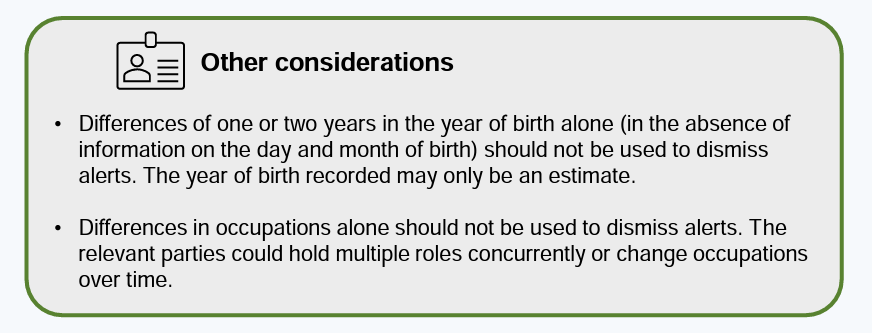

## Date of birth similarity

In [ ]:
# inner join nodes_df (customer) + matches_df (customer_target pair)
# left join person_detailed (target) on 'caption', 'name', 'alias', 'weakAlias', 'previousName' to capture all possible matches based on target_id and target_side
bday_matches = nodes_df[['CUSTOMER_ID', 'NAME', 'BIRTH_DT']].\
merge(matches_df[['customer_id', 'customer_side', 'target_id', 'target_side']], left_on = 'CUSTOMER_ID', right_on = 'customer_id', how = 'inner').\
merge(person_detailed[['id', 'caption', 'birthDate']], left_on = ['target_id', 'target_side'], right_on = ['id', 'caption'], how = 'left', suffixes = (None, '_1')).\
merge(person_detailed[['id', 'name', 'birthDate']], left_on = ['target_id', 'target_side'], right_on = ['id', 'name'], how = 'left', suffixes = (None, '_2')).\
merge(person_detailed[['id', 'alias', 'birthDate']], left_on = ['target_id', 'target_side'], right_on = ['id', 'alias'], how = 'left', suffixes = (None, '_3')).\
merge(person_detailed[['id', 'weakAlias', 'birthDate']], left_on = ['target_id', 'target_side'], right_on = ['id', 'weakAlias'], how = 'left', suffixes = (None, '_4')).\
merge(person_detailed[['id', 'previousName', 'birthDate']], left_on = ['target_id', 'target_side'], right_on = ['id', 'previousName'], how = 'left', suffixes = (None, '_5'))

In [ ]:
bday_matches.columns

Index(['CUSTOMER_ID', 'NAME', 'BIRTH_DT', 'customer_id', 'customer_side',
       'target_id', 'target_side', 'id', 'caption', 'birthDate', 'id_2',
       'name', 'birthDate_2', 'id_3', 'alias', 'birthDate_3', 'id_4',
       'weakAlias', 'birthDate_4', 'id_5', 'previousName', 'birthDate_5'],
      dtype='object')

In [ ]:
bday_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5377306 entries, 0 to 5377305
Data columns (total 22 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   CUSTOMER_ID    object
 1   NAME           object
 2   BIRTH_DT       object
 3   customer_id    object
 4   customer_side  object
 5   target_id      object
 6   target_side    object
 7   id             object
 8   caption        object
 9   birthDate      object
 10  id_2           object
 11  name           object
 12  birthDate_2    object
 13  id_3           object
 14  alias          object
 15  birthDate_3    object
 16  id_4           object
 17  weakAlias      object
 18  birthDate_4    object
 19  id_5           object
 20  previousName   object
 21  birthDate_5    object
dtypes: object(22)
memory usage: 943.6+ MB


In [ ]:
# nan in birthDate, birthDate_2, birthDate_3, birthDate_4, birthDate_5
bday_matches.loc[:, ['birth' in x for x in bday_matches.columns]].isna().sum(axis=1).describe()

count   5377306.0000
mean          3.5584
std           0.8675
min           1.0000
25%           3.0000
50%           3.0000
75%           4.0000
max           5.0000
dtype: float64

In [ ]:
# some dates are in the format of yyyy instead of yyyy-mm-dd
for bday_col in [x for x in bday_matches.columns if ('birthDate' in x) or ('BIRTH_DT' in x)]:
  print(bday_col, sorted(bday_matches[bday_col].dropna(), key = len)[:3])

BIRTH_DT ['1942-01-24', '1942-01-24', '1942-01-24']
birthDate ['1942', '1957', '1952']
birthDate_2 ['1942', '1957', '1952']
birthDate_3 ['1994', '1980', '1960']
birthDate_4 ['1964', '1954', '1964']
birthDate_5 []


In [ ]:
# these dates are treated as Jan 01 when being converted to date
pd.to_datetime(bday_matches.loc[bday_matches.birthDate == '1967', 'birthDate'])

777       1967-01-01
1634      1967-01-01
1894      1967-01-01
2865      1967-01-01
3326      1967-01-01
             ...    
5375198   1967-01-01
5375284   1967-01-01
5375890   1967-01-01
5376054   1967-01-01
5376370   1967-01-01
Name: birthDate, Length: 12423, dtype: datetime64[ns]

In [ ]:
# convert to datetime
for bday_col in [x for x in bday_matches.columns if ('birthDate' in x) or ('BIRTH_DT' in x)]:
  bday_matches[bday_col] = pd.to_datetime(bday_matches[bday_col], errors = 'coerce')

In [ ]:
bday_matches[[x for x in bday_matches.columns if ('birthDate' in x)]].apply(lambda x: abs(x - bday_matches.BIRTH_DT), axis = 0)

,birthDate,birthDate_2,birthDate_3,birthDate_4,birthDate_5
0,9202 days,9202 days,NaT,NaT,NaT
1,6324 days,6324 days,NaT,NaT,NaT
2,17849 days,17849 days,NaT,NaT,NaT
3,23 days,23 days,NaT,NaT,NaT
4,NaT,NaT,6324 days,NaT,NaT
...,...,...,...,...,...
5377301,3874 days,3874 days,NaT,NaT,NaT
5377302,11584 days,11584 days,NaT,NaT,NaT
5377303,NaT,NaT,NaT,NaT,NaT
5377304,6943 days,6943 days,NaT,NaT,NaT


In [ ]:
# average difference in days based on matches between target_side and caption / name / alias / weakAlias / previousName
# if entire row = NA then NA
# else average of numeric values
bday_difference = bday_matches[[x for x in bday_matches.columns if ('birthDate' in x)]].apply(lambda x: abs(x - bday_matches.BIRTH_DT), axis = 0).mean(axis=1).apply(lambda x: x.days)
bday_difference

0          9202.0000
1          6324.0000
2         17849.0000
3            23.0000
4          6324.0000
             ...    
5377301    3874.0000
5377302   11584.0000
5377303          NaN
5377304    6943.0000
5377305          NaN
Length: 5377306, dtype: float64

In [ ]:
# merge bday_difference with matches_df 
bday_matches['bday_difference'] = bday_difference
matches_all = copy.deepcopy(matches_df[['customer_id', 'customer_side', 'target_id', 'target_side', 'cosine_similarity']])
matches_all = matches_all.merge(bday_matches[['customer_id', 'customer_side', 'target_id', 'target_side', 'bday_difference']], 
                                how = 'inner', on = ['customer_id', 'customer_side', 'target_id', 'target_side'])
matches_all.to_pickle('matches_all.pkl')

In [ ]:
matches_all.sort_values('bday_difference', ascending=True).head(10)

,customer_id,customer_side,target_id,target_side,cosine_similarity,bday_difference
2829796,783054,Michael Delo,Q1772865,Åse Michaelsen,0.5270,0.0000
2615065,259084,Christopher Warren Jackson,Q32722,Christopher P. Gibson,0.5330,0.0000
5280845,841429,Katherine Burns,Q63763278,Catherine Cuzin,0.5000,0.0000
5251319,752474,Christian Sarabia,Q63763034,Christiane Brunet,0.5000,0.0000
1437787,20981,James Johnson,Q76449002,Kim Johnson,0.5590,0.0000
947185,199900,"Basova, Lidiya Oleksandrivna",NK-7dwYVASfwQMKGmJBWWEVYt,Lidia Aleksandrovna BASOVA,0.5779,0.0000
3340709,707354,Michelle George,Q24048985,Michelle Brown,0.5222,0.0000
1104197,462713,"White, Jennifer",Q64968814,Jennifer Taub,0.5721,0.0000
523624,376264,"Oleksin, Alexei Ivanovich",Q64438502,Alexei Oleksin,0.6068,0.0000
4285054,306224,John Williams,Q76337439,William Skidelsky,0.5071,0.0000


In [ ]:
matches_all.isna().sum()

customer_id                0
customer_side              0
target_id                  0
target_side                0
cosine_similarity          0
bday_difference      1140913
dtype: int64

In [ ]:
# check
person_detailed[person_detailed.id == 'Q459603']

,datasets,id,target,caption,name,alias,weakAlias,previousName,birthDate,gender,country,nationality
151448,wikidata,Q459603,True,Alison Redford,Alison Redford,اليسون ريدفورد,NaN,NaN,1965-03-07,female,ca,ca


In [ ]:
# check
nodes_df.loc[nodes_df.CUSTOMER_ID == '359412', ['BIRTH_DT', 'NAME', 'CUSTOMER_ID']]

,BIRTH_DT,NAME,CUSTOMER_ID
125672,1965-03-07,Alison Merrilla Redford,359412


In [ ]:
# check
bday_matches[(bday_matches.CUSTOMER_ID == '359412') & (bday_matches.target_id == 'Q459603')]

,CUSTOMER_ID,NAME,BIRTH_DT,customer_id,customer_side,target_id,target_side,id,caption,birthDate,id_2,name,birthDate_2,id_3,alias,birthDate_3,id_4,weakAlias,birthDate_4,id_5,previousName,birthDate_5,bday_difference
669244,359412,Alison Merrilla Redford,1965-03-07,359412,Alison Merrilla Redford,Q459603,Alison Redford,Q459603,Alison Redford,1965-03-07,Q459603,Alison Redford,1965-03-07,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,0.0000


## country similarity
- https://www.opensanctions.org/reference/#countries
- nodes_df: RES_CNTRY_CA, CNTRY_OF_INCOME_CA
- person_detailed: country, nationality

In [ ]:
# if ca then 1
# if others then -1
# if nan then nan (will be considered as 0 as we sum country and nationality)
# if ('RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA') = (1,1) and ('country', 'nationality') = (1, nan) -> distance = 2 - 1 = 1
# if ('RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA') = (1,1) and ('country', 'nationality') = (1, -1) -> distance = 2 - 0 = 2 (if we know for sure it's another country, we should penalize it)
person_CA = copy.deepcopy(person_detailed)
person_CA.loc[:, 'country'] = person_CA.country.replace({'ca':1}).replace('[a-zA-Z]+', -1, regex=True).astype(float)
person_CA.loc[:, 'nationality'] = person_CA.nationality.replace({'ca':1}).replace('[a-zA-Z]+', -1, regex=True).astype(float)


# left join on 'caption', 'name', 'alias', 'weakAlias', 'previousName' to capture all possible matches on target_id
country_matches = nodes_df[['CUSTOMER_ID', 'NAME', 'RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA']].\
merge(matches_df[['customer_id', 'customer_side', 'target_id', 'target_side']], left_on = 'CUSTOMER_ID', right_on = 'customer_id', how = 'inner').\
merge(person_CA[['id', 'caption', 'country', 'nationality']], left_on = ['target_id', 'target_side'], right_on = ['id', 'caption'], how = 'left', suffixes = (None, '_1')).\
merge(person_CA[['id', 'name', 'country', 'nationality']], left_on = ['target_id', 'target_side'], right_on = ['id', 'name'], how = 'left', suffixes = (None, '_2')).\
merge(person_CA[['id', 'alias', 'country', 'nationality']], left_on = ['target_id', 'target_side'], right_on = ['id', 'alias'], how = 'left', suffixes = (None, '_3')).\
merge(person_CA[['id', 'weakAlias', 'country', 'nationality']], left_on = ['target_id', 'target_side'], right_on = ['id', 'weakAlias'], how = 'left', suffixes = (None, '_4')).\
merge(person_CA[['id', 'previousName', 'country', 'nationality']], left_on = ['target_id', 'target_side'], right_on = ['id', 'previousName'], how = 'left', suffixes = (None, '_5'))

In [ ]:
country_matches

,CUSTOMER_ID,NAME,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,customer_id,customer_side,target_id,target_side,id,caption,country,nationality,id_2,name,country_2,nationality_2,id_3,alias,country_3,nationality_3,id_4,weakAlias,country_4,nationality_4,id_5,previousName,country_5,nationality_5
0,418265,Carolyn Washington Roberts,1,1,418265,Carolyn Washington Roberts,Q10393239,WASHINGTON REIS,Q10393239,WASHINGTON REIS,-1.0000,-1.0000,Q10393239,WASHINGTON REIS,-1.0000,-1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,418265,Carolyn Washington Roberts,1,1,418265,Carolyn Washington Roberts,Q10393365,WELLINGTON ROBERTO,Q10393365,WELLINGTON ROBERTO,-1.0000,-1.0000,Q10393365,WELLINGTON ROBERTO,-1.0000,-1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,418265,Carolyn Washington Roberts,1,1,418265,Carolyn Washington Roberts,Q75547865,Robert Carington,Q75547865,Robert Carington,NaN,NaN,Q75547865,Robert Carington,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,418265,Carolyn Washington Roberts,1,1,418265,Carolyn Washington Roberts,Q66821534,Carol R. Roberts,Q66821534,Carol R. Roberts,-1.0000,-1.0000,Q66821534,Carol R. Roberts,-1.0000,-1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,418265,Carolyn Washington Roberts,1,1,418265,Carolyn Washington Roberts,Q10393365,José Wellington Roberto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q10393365,José Wellington Roberto,-1.0000,-1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5377301,166357,Daniel Mckeighan,0,0,166357,Daniel Mckeighan,Q5218111,Daniel McKee,Q5218111,Daniel McKee,-1.0000,-1.0000,Q5218111,Daniel McKee,-1.0000,-1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5377302,166357,Daniel Mckeighan,0,0,166357,Daniel Mckeighan,Q7816862,Daniel McVeigh,Q7816862,Daniel McVeigh,NaN,-1.0000,Q7816862,Daniel McVeigh,NaN,-1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5377303,166357,Daniel Mckeighan,0,0,166357,Daniel Mckeighan,Q16732232,Daniel McCay,Q16732232,Daniel McCay,-1.0000,-1.0000,Q16732232,Daniel McCay,-1.0000,-1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5377304,166357,Daniel Mckeighan,0,0,166357,Daniel Mckeighan,Q1161706,Daniel May,Q1161706,Daniel May,-1.0000,-1.0000,Q1161706,Daniel May,-1.0000,-1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
customer_country_matches = country_matches[['RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA']].sum(axis=1)

target_country_matches = pd.concat([
    # average match in country == ca
    # nan if entire row is na
    country_matches[[x for x in country_matches.columns if ('country' in x)]].mean(axis=1), 
    # average match in nationality == ca
    # nan if entire row is na
    country_matches[[x for x in country_matches.columns if ('nationality' in x)]].mean(axis=1)], axis=1).\
    sum(axis=1)

In [ ]:
# define similarity as 1 - abs(diff) / abs_max(diff)
country_matches['country_similarity'] = 1 - abs(customer_country_matches - target_country_matches) / (customer_country_matches - target_country_matches).abs().max()
country_matches['country_similarity'] = (country_matches['country_similarity'] == 1).astype(float)
country_matches['country_similarity']

0         0.0000
1         0.0000
2         0.0000
3         0.0000
4         0.0000
           ...  
5377301   0.0000
5377302   0.0000
5377303   0.0000
5377304   0.0000
5377305   0.0000
Name: country_similarity, Length: 5377306, dtype: float64

In [ ]:
country_matches['country_similarity'].value_counts(dropna=False).sort_index()

0.0000    5216729
1.0000     160577
Name: country_similarity, dtype: int64

In [ ]:
matches_all = matches_all.merge(country_matches[['customer_id', 'customer_side', 'target_id', 'target_side', 'country_similarity']], 
                                how = 'inner', on = ['customer_id', 'customer_side', 'target_id', 'target_side'])
matches_all.to_pickle('matches_all.pkl')

In [ ]:
matches_all

,customer_id,customer_side,target_id,target_side,cosine_similarity,bday_difference,country_similarity
0,487705,John Stevens,Q1236990,John Stevens,1.0000,8880.0000,0.0000
1,960001,Jennifer Knight,Q104046574,Jennifer Knight,1.0000,16137.0000,0.0000
2,2189,Paula Miller,Q7154730,Paula Miller,1.0000,6116.0000,0.0000
3,72076,Robert Williams,Q111322463,Robert Williams,1.0000,5733.0000,0.0000
4,823262,Paul Sanders,Q19360631,Paul Sanders,1.0000,20060.0000,0.0000
...,...,...,...,...,...,...,...
5378399,359868,G\teorg,Q669384,Georgi Atanasov,0.5000,9034.0000,0.0000
5378400,359868,G\teorg,Q12276470,Georgi Yordanov,0.5000,8726.0000,0.0000
5378401,359868,G\teorg,Q7612638,Steve Georganas,0.5000,420.0000,0.0000
5378402,359868,G\teorg,Q120013,Georges Theiler,0.5000,3256.0000,0.0000


In [ ]:
matches_all.isna().sum()

customer_id                 0
customer_side               0
target_id                   0
target_side                 0
cosine_similarity           0
bday_difference       1140922
country_similarity          0
dtype: int64

## PEP similarity
- https://www.opensanctions.org/datasets/default/#sources

In [ ]:
# https://www.opensanctions.org/datasets/peps/
pep_databases = ['wikidata', 'wd_peppercat_legislators', 'everypolitician', 'wd_peppercat_leaders', 'ru_rupep', 'us_cia_world_leaders', 'eu_meps', 'eu_cor_members']

In [ ]:
np.unique(nodes_df.PEP_FL, return_counts=True)

(array([0., 1.]), array([902511,  97489], dtype=int64))

In [ ]:
# True = 1, False = 0, NAN = NAN
nodes_PEP = copy.deepcopy(nodes_df)
person_PEP = copy.deepcopy(person_detailed)
person_PEP.loc[:, 'target_PEP'] = 0
person_PEP.loc[person_PEP['datasets'].isna(), 'target_PEP'] = np.nan
person_PEP.loc[person_PEP['datasets'].isin(pep_databases), 'target_PEP'] = 1

# left join on 'caption', 'name', 'alias', 'weakAlias', 'previousName' to capture all possible matches on target_id
PEP_matches = nodes_PEP[['CUSTOMER_ID', 'NAME', 'PEP_FL']].\
merge(matches_df[['customer_id', 'customer_side', 'target_id', 'target_side']], left_on = 'CUSTOMER_ID', right_on = 'customer_id', how = 'inner').\
merge(person_PEP[['id', 'caption', 'target_PEP']], left_on = ['target_id', 'target_side'], right_on = ['id', 'caption'], how = 'left', suffixes = (None, '_1')).\
merge(person_PEP[['id', 'name', 'target_PEP']], left_on = ['target_id', 'target_side'], right_on = ['id', 'name'], how = 'left', suffixes = (None, '_2')).\
merge(person_PEP[['id', 'alias', 'target_PEP']], left_on = ['target_id', 'target_side'], right_on = ['id', 'alias'], how = 'left', suffixes = (None, '_3')).\
merge(person_PEP[['id', 'weakAlias', 'target_PEP']], left_on = ['target_id', 'target_side'], right_on = ['id', 'weakAlias'], how = 'left', suffixes = (None, '_4')).\
merge(person_PEP[['id', 'previousName', 'target_PEP']], left_on = ['target_id', 'target_side'], right_on = ['id', 'previousName'], how = 'left', suffixes = (None, '_5'))


In [ ]:
person_PEP.target_PEP.value_counts(dropna=False)

1.0000    212944
0.0000     44219
Name: target_PEP, dtype: int64

In [ ]:
# PEP_matches

In [ ]:
# check consistency across target_PEP, target_PEP_2, target_PEP_3, ...
PEP_matches[[x for x in PEP_matches.columns if ('target_PEP' in x)]].mean(axis=1).value_counts(dropna=False)

1.0000    4840621
0.0000     536685
dtype: int64

In [ ]:
# check if PEP_FL in customer database matches PEP_FL in sanction list
PEP_diff = PEP_matches.PEP_FL - PEP_matches[[x for x in PEP_matches.columns if ('target_PEP' in x)]].mean(axis=1)
PEP_matches['PEP_similarity'] = 1 - abs(PEP_diff) / max(abs(PEP_diff))

In [ ]:
# check consistency
PEP_matches['PEP_similarity'].value_counts(dropna=False)

0.0000    4416844
1.0000     960462
Name: PEP_similarity, dtype: int64

In [ ]:
# should not assume it's PEP: PEP_similarity = 1 iff PEP_FL in customer database = 1 and PEP_FL in sanction list = 1
PEP_matches['PEP_matches'] = (PEP_matches.PEP_FL.astype(bool) & PEP_matches['PEP_similarity'].astype(bool)).astype(float)

In [ ]:
matches_all = matches_all.merge(PEP_matches[['customer_id', 'customer_side', 'target_id', 'target_side', 'PEP_similarity', 'PEP_matches']], 
                                how = 'inner', on = ['customer_id', 'customer_side', 'target_id', 'target_side'])
matches_all.to_pickle('matches_all.pkl')

In [ ]:
matches_all

C:\Users\WilliamKwok\anaconda3\envs\py9\lib\site-packages\IPython\core\displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,customer_id,customer_side,target_id,target_side,cosine_similarity,bday_difference,country_similarity,PEP_similarity,PEP_matches
0,487705,John Stevens,Q1236990,John Stevens,1.0000,8880.0000,0.0000,0.0000,0.0000
1,960001,Jennifer Knight,Q104046574,Jennifer Knight,1.0000,16137.0000,0.0000,0.0000,0.0000
2,2189,Paula Miller,Q7154730,Paula Miller,1.0000,6116.0000,0.0000,0.0000,0.0000
3,72076,Robert Williams,Q111322463,Robert Williams,1.0000,5733.0000,0.0000,0.0000,0.0000
4,823262,Paul Sanders,Q19360631,Paul Sanders,1.0000,20060.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...
5382731,359868,G\teorg,Q669384,Georgi Atanasov,0.5000,9034.0000,0.0000,0.0000,0.0000
5382732,359868,G\teorg,Q12276470,Georgi Yordanov,0.5000,8726.0000,0.0000,0.0000,0.0000
5382733,359868,G\teorg,Q7612638,Steve Georganas,0.5000,420.0000,0.0000,0.0000,0.0000
5382734,359868,G\teorg,Q120013,Georges Theiler,0.5000,3256.0000,0.0000,0.0000,0.0000


In [ ]:
matches_all.isna().sum()

customer_id                 0
customer_side               0
target_id                   0
target_side                 0
cosine_similarity           0
bday_difference       1140958
country_similarity          0
PEP_similarity              0
PEP_matches                 0
dtype: int64

## Gender similarity

In [ ]:
nodes_df.GENDER.unique()

array(['Female', 'Male', nan], dtype=object)

In [ ]:
person_detailed.gender.unique()

array(['male', 'female', nan, 'other'], dtype=object)

In [ ]:
person_detailed.gender.replace({'male': 1, 'female': 0, np.nan: np.nan, 'other': np.nan}).value_counts(dropna=False)

1.0000    139120
NaN        71382
0.0000     46661
Name: gender, dtype: int64

In [ ]:
# Male = 1, Female = 0, others / NAN = NAN
nodes_gender = copy.deepcopy(nodes_df)
nodes_gender.GENDER = nodes_gender.GENDER.replace({'Male': 1, 'Female': 0, np.nan: np.nan, 'Other': np.nan})
person_gender = copy.deepcopy(person_detailed)
person_gender.loc[:,'target_gender'] = person_gender.gender.replace({'male': 1, 'female': 0, np.nan: np.nan, 'other': np.nan})

# left join on 'caption', 'name', 'alias', 'weakAlias', 'previousName' to capture all possible matches on target_id
gender_matches = nodes_gender[['CUSTOMER_ID', 'NAME', 'GENDER']].\
merge(matches_df[['customer_id', 'customer_side', 'target_id', 'target_side']], left_on = 'CUSTOMER_ID', right_on = 'customer_id', how = 'inner').\
merge(person_gender[['id', 'caption', 'target_gender']], left_on = ['target_id', 'target_side'], right_on = ['id', 'caption'], how = 'left', suffixes = (None, '_1')).\
merge(person_gender[['id', 'name', 'target_gender']], left_on = ['target_id', 'target_side'], right_on = ['id', 'name'], how = 'left', suffixes = (None, '_2')).\
merge(person_gender[['id', 'alias', 'target_gender']], left_on = ['target_id', 'target_side'], right_on = ['id', 'alias'], how = 'left', suffixes = (None, '_3')).\
merge(person_gender[['id', 'weakAlias', 'target_gender']], left_on = ['target_id', 'target_side'], right_on = ['id', 'weakAlias'], how = 'left', suffixes = (None, '_4')).\
merge(person_gender[['id', 'previousName', 'target_gender']], left_on = ['target_id', 'target_side'], right_on = ['id', 'previousName'], how = 'left', suffixes = (None, '_5'))


In [ ]:
gender_matches

,CUSTOMER_ID,NAME,GENDER,customer_id,customer_side,target_id,target_side,id,caption,target_gender,id_2,name,target_gender_2,id_3,alias,target_gender_3,id_4,weakAlias,target_gender_4,id_5,previousName,target_gender_5
0,418265,Carolyn Washington Roberts,0.0000,418265,Carolyn Washington Roberts,Q10393239,WASHINGTON REIS,Q10393239,WASHINGTON REIS,1.0000,Q10393239,WASHINGTON REIS,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,418265,Carolyn Washington Roberts,0.0000,418265,Carolyn Washington Roberts,Q10393365,WELLINGTON ROBERTO,Q10393365,WELLINGTON ROBERTO,1.0000,Q10393365,WELLINGTON ROBERTO,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,418265,Carolyn Washington Roberts,0.0000,418265,Carolyn Washington Roberts,Q75547865,Robert Carington,Q75547865,Robert Carington,1.0000,Q75547865,Robert Carington,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,418265,Carolyn Washington Roberts,0.0000,418265,Carolyn Washington Roberts,Q66821534,Carol R. Roberts,Q66821534,Carol R. Roberts,0.0000,Q66821534,Carol R. Roberts,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,418265,Carolyn Washington Roberts,0.0000,418265,Carolyn Washington Roberts,Q10393365,José Wellington Roberto,NaN,NaN,NaN,NaN,NaN,NaN,Q10393365,José Wellington Roberto,1.0000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5377301,166357,Daniel Mckeighan,1.0000,166357,Daniel Mckeighan,Q5218111,Daniel McKee,Q5218111,Daniel McKee,1.0000,Q5218111,Daniel McKee,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5377302,166357,Daniel Mckeighan,1.0000,166357,Daniel Mckeighan,Q7816862,Daniel McVeigh,Q7816862,Daniel McVeigh,1.0000,Q7816862,Daniel McVeigh,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5377303,166357,Daniel Mckeighan,1.0000,166357,Daniel Mckeighan,Q16732232,Daniel McCay,Q16732232,Daniel McCay,1.0000,Q16732232,Daniel McCay,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5377304,166357,Daniel Mckeighan,1.0000,166357,Daniel Mckeighan,Q1161706,Daniel May,Q1161706,Daniel May,1.0000,Q1161706,Daniel May,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# check consistency
gender_matches[[x for x in gender_matches.columns if ('target_gender' in x)]].mean(axis=1).value_counts(dropna=False)

1.0000    3569618
0.0000    1156068
NaN        651620
dtype: int64

In [ ]:
gender_matches[[x for x in gender_matches.columns if ('target_gender' in x)]]

,target_gender,target_gender_2,target_gender_3,target_gender_4,target_gender_5
0,1.0000,1.0000,NaN,NaN,NaN
1,1.0000,1.0000,NaN,NaN,NaN
2,1.0000,1.0000,NaN,NaN,NaN
3,0.0000,0.0000,NaN,NaN,NaN
4,NaN,NaN,1.0000,NaN,NaN
...,...,...,...,...,...
5377301,1.0000,1.0000,NaN,NaN,NaN
5377302,1.0000,1.0000,NaN,NaN,NaN
5377303,1.0000,1.0000,NaN,NaN,NaN
5377304,1.0000,1.0000,NaN,NaN,NaN


In [ ]:
# if entire row is NAN then keep NAN
gender_matches[[x for x in gender_matches.columns if ('target_gender' in x)]].mean(axis=1)

0         1.0000
1         1.0000
2         1.0000
3         0.0000
4         1.0000
           ...  
5377301   1.0000
5377302   1.0000
5377303   1.0000
5377304   1.0000
5377305   1.0000
Length: 5377306, dtype: float64

In [ ]:
gender_diff = gender_matches.GENDER - gender_matches[[x for x in gender_matches.columns if ('target_gender' in x)]].mean(axis=1)
gender_matches['gender_similarity'] = 1 - abs(gender_diff) / max(abs(gender_diff))

In [ ]:
# check consistency
gender_matches['gender_similarity'].value_counts(dropna=False)

1.0000    3722132
0.0000    1003554
NaN        651620
Name: gender_similarity, dtype: int64

In [ ]:
matches_all = matches_all.merge(gender_matches[['customer_id', 'customer_side', 'target_id', 'target_side', 'gender_similarity']], 
                                how = 'inner', on = ['customer_id', 'customer_side', 'target_id', 'target_side'])
matches_all.to_pickle('matches_all.pkl')

In [ ]:
matches_all

,customer_id,customer_side,target_id,target_side,cosine_similarity,bday_difference,country_similarity,PEP_similarity,PEP_matches,gender_similarity
0,487705,John Stevens,Q1236990,John Stevens,1.0000,8880.0000,0.0000,0.0000,0.0000,1.0000
1,960001,Jennifer Knight,Q104046574,Jennifer Knight,1.0000,16137.0000,0.0000,0.0000,0.0000,1.0000
2,2189,Paula Miller,Q7154730,Paula Miller,1.0000,6116.0000,0.0000,0.0000,0.0000,1.0000
3,72076,Robert Williams,Q111322463,Robert Williams,1.0000,5733.0000,0.0000,0.0000,0.0000,1.0000
4,823262,Paul Sanders,Q19360631,Paul Sanders,1.0000,20060.0000,0.0000,0.0000,0.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...
5399939,359868,G\teorg,Q669384,Georgi Atanasov,0.5000,9034.0000,0.0000,0.0000,0.0000,1.0000
5399940,359868,G\teorg,Q12276470,Georgi Yordanov,0.5000,8726.0000,0.0000,0.0000,0.0000,1.0000
5399941,359868,G\teorg,Q7612638,Steve Georganas,0.5000,420.0000,0.0000,0.0000,0.0000,1.0000
5399942,359868,G\teorg,Q120013,Georges Theiler,0.5000,3256.0000,0.0000,0.0000,0.0000,1.0000


In [ ]:
matches_all.isna().sum()

customer_id                 0
customer_side               0
target_id                   0
target_side                 0
cosine_similarity           0
bday_difference       1141102
country_similarity          0
PEP_similarity              0
PEP_matches                 0
gender_similarity      651620
dtype: int64

## Target or non-target indicator

In [ ]:
person_detailed.target.unique()

array([ True, False])

In [ ]:
person_target = copy.deepcopy(person_detailed)
person_target['target_bool'] = person_detailed.target.replace({True:1, False:0})

In [ ]:
# left join on 'caption', 'name', 'alias', 'weakAlias', 'previousName' to capture all possible matches on target_id
target_matches = nodes_df[['CUSTOMER_ID', 'NAME']].\
merge(matches_df[['customer_id', 'customer_side', 'target_id', 'target_side']], left_on = 'CUSTOMER_ID', right_on = 'customer_id', how = 'inner').\
merge(person_target[['id', 'caption', 'target_bool']], left_on = ['target_id', 'target_side'], right_on = ['id', 'caption'], how = 'left', suffixes = (None, '_1')).\
merge(person_target[['id', 'name', 'target_bool']], left_on = ['target_id', 'target_side'], right_on = ['id', 'name'], how = 'left', suffixes = (None, '_2')).\
merge(person_target[['id', 'alias', 'target_bool']], left_on = ['target_id', 'target_side'], right_on = ['id', 'alias'], how = 'left', suffixes = (None, '_3')).\
merge(person_target[['id', 'weakAlias', 'target_bool']], left_on = ['target_id', 'target_side'], right_on = ['id', 'weakAlias'], how = 'left', suffixes = (None, '_4')).\
merge(person_target[['id', 'previousName', 'target_bool']], left_on = ['target_id', 'target_side'], right_on = ['id', 'previousName'], how = 'left', suffixes = (None, '_5'))


In [ ]:
target_matches

,CUSTOMER_ID,NAME,customer_id,customer_side,target_id,target_side,id,caption,target_bool,id_2,name,target_bool_2,id_3,alias,target_bool_3,id_4,weakAlias,target_bool_4,id_5,previousName,target_bool_5
0,418265,Carolyn Washington Roberts,418265,Carolyn Washington Roberts,Q10393239,WASHINGTON REIS,Q10393239,WASHINGTON REIS,1.0000,Q10393239,WASHINGTON REIS,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,418265,Carolyn Washington Roberts,418265,Carolyn Washington Roberts,Q10393365,WELLINGTON ROBERTO,Q10393365,WELLINGTON ROBERTO,1.0000,Q10393365,WELLINGTON ROBERTO,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,418265,Carolyn Washington Roberts,418265,Carolyn Washington Roberts,Q75547865,Robert Carington,Q75547865,Robert Carington,0.0000,Q75547865,Robert Carington,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,418265,Carolyn Washington Roberts,418265,Carolyn Washington Roberts,Q66821534,Carol R. Roberts,Q66821534,Carol R. Roberts,1.0000,Q66821534,Carol R. Roberts,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,418265,Carolyn Washington Roberts,418265,Carolyn Washington Roberts,Q10393365,José Wellington Roberto,NaN,NaN,NaN,NaN,NaN,NaN,Q10393365,José Wellington Roberto,1.0000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5377301,166357,Daniel Mckeighan,166357,Daniel Mckeighan,Q5218111,Daniel McKee,Q5218111,Daniel McKee,1.0000,Q5218111,Daniel McKee,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5377302,166357,Daniel Mckeighan,166357,Daniel Mckeighan,Q7816862,Daniel McVeigh,Q7816862,Daniel McVeigh,1.0000,Q7816862,Daniel McVeigh,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5377303,166357,Daniel Mckeighan,166357,Daniel Mckeighan,Q16732232,Daniel McCay,Q16732232,Daniel McCay,1.0000,Q16732232,Daniel McCay,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5377304,166357,Daniel Mckeighan,166357,Daniel Mckeighan,Q1161706,Daniel May,Q1161706,Daniel May,1.0000,Q1161706,Daniel May,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# check consistency
target_matches[[x for x in target_matches.columns if ('target_bool' in x)]].mean(axis=1).value_counts(dropna=False)

1.0000    4902512
0.0000     474787
0.5000          4
0.3333          2
0.6667          1
dtype: int64

In [ ]:
# this name is a target in one dataset, non-target in another dataset
person_target[person_target.id == 'Q6752973']

,datasets,id,target,caption,name,alias,weakAlias,previousName,birthDate,gender,country,nationality,target_bool
53441,wikidata,Q6752973,False,Manuel de Freitas,Manuel de Freitas,Manuel Simão Franca De Freitas,NaN,NaN,1972,male,NaN,pt,0
193133,everypolitician,Q6752973,True,Manuel Simão Franca De Freitas,Manuel Simão Franca De Freitas,Manuel de Freitas,NaN,NaN,1968-10-28,male,NaN,za,1


In [ ]:
target_matches['target_similarity'] = target_matches[[x for x in target_matches.columns if ('target_bool' in x)]].mean(axis=1)

In [ ]:
matches_all = matches_all.merge(target_matches[['customer_id', 'customer_side', 'target_id', 'target_side', 'target_similarity']], 
                                how = 'inner', on = ['customer_id', 'customer_side', 'target_id', 'target_side'])
matches_all.to_pickle('matches_all.pkl')

# output as matches_all (check if duplicated target_id)

In [ ]:
matches_all = pd.read_pickle('matches_all.pkl')
matches_all.customer_id = matches_all.customer_id.astype(str)
matches_all

,customer_id,customer_side,target_id,target_side,cosine_similarity,bday_difference,country_similarity,PEP_similarity,PEP_matches,gender_similarity,target_similarity
0,487705,John Stevens,Q1236990,John Stevens,1.0000,8880.0000,0.0000,0.0000,0.0000,1.0000,1.0000
1,960001,Jennifer Knight,Q104046574,Jennifer Knight,1.0000,16137.0000,0.0000,0.0000,0.0000,1.0000,1.0000
2,2189,Paula Miller,Q7154730,Paula Miller,1.0000,6116.0000,0.0000,0.0000,0.0000,1.0000,1.0000
3,72076,Robert Williams,Q111322463,Robert Williams,1.0000,5733.0000,0.0000,0.0000,0.0000,1.0000,1.0000
4,823262,Paul Sanders,Q19360631,Paul Sanders,1.0000,20060.0000,0.0000,0.0000,0.0000,1.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...
5468531,359868,G\teorg,Q669384,Georgi Atanasov,0.5000,9034.0000,0.0000,0.0000,0.0000,1.0000,1.0000
5468532,359868,G\teorg,Q12276470,Georgi Yordanov,0.5000,8726.0000,0.0000,0.0000,0.0000,1.0000,1.0000
5468533,359868,G\teorg,Q7612638,Steve Georganas,0.5000,420.0000,0.0000,0.0000,0.0000,1.0000,1.0000
5468534,359868,G\teorg,Q120013,Georges Theiler,0.5000,3256.0000,0.0000,0.0000,0.0000,1.0000,1.0000


In [ ]:
matches_all.describe()

,cosine_similarity,bday_difference,country_similarity,PEP_similarity,PEP_matches,gender_similarity,target_similarity
count,5468536.0000,4326858.0000,5468536.0000,5468536.0000,5468536.0000,4816916.0000,5468536.0000
mean,0.5455,8185.9898,0.0294,0.1773,0.0885,0.7901,0.9130
std,0.0491,6014.7433,0.1688,0.3819,0.2840,0.4072,0.2818
min,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.5103,3331.0000,0.0000,0.0000,0.0000,1.0000,1.0000
50%,0.5298,7047.0000,0.0000,0.0000,0.0000,1.0000,1.0000
75%,0.5634,11888.0000,0.0000,0.0000,0.0000,1.0000,1.0000
max,1.0000,43187.0000,1.0000,1.0000,1.0000,1.0000,1.0000


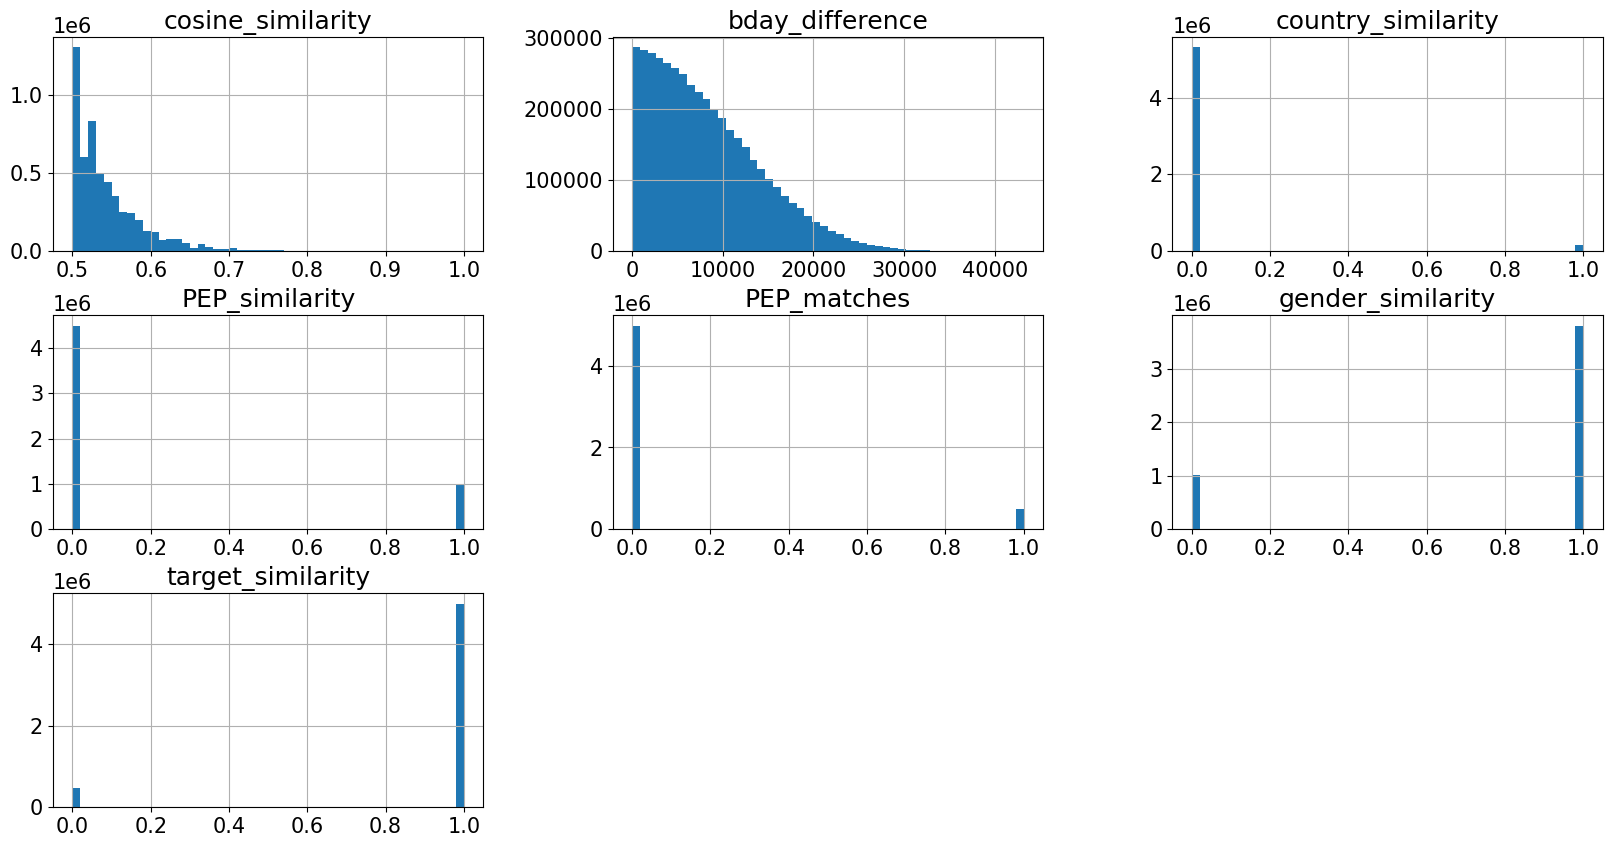

In [ ]:
matches_all.hist(bins = 50, layout = (3, int(matches_all.select_dtypes(np.number).shape[1] / 3) + 1), figsize= (20,10))
plt.show()

### prioritize 1) exact name match, 2) exact gender match

In [ ]:
matches_all_copy = copy.deepcopy(matches_all)

## Custom threshold

In [ ]:
# exact match in name + bday or gender (in case there is NA in either gender or bday but exact match in name)
matches_all_copy['exact_match_threshold'] = (((matches_all_copy.cosine_similarity >= 0.999) & (matches_all_copy.gender_similarity == 1)) | (matches_all_copy.cosine_similarity >= 0.999) & (matches_all_copy.bday_difference == 0)).astype(float)
# bday within 2 years
matches_all_copy['bday_threshold'] = (matches_all_copy.bday_difference <= 2 * 365).astype(float)
# name >= 3 words in either OpenSanctions database or Customer database (avoid just matching by first and last name)
matches_all_copy['name_threshold'] = ((matches_all_copy.customer_side.str.split(' ').apply(lambda x: len(x)) >= 3) | (matches_all_copy.target_side.str.split(' ').apply(lambda x: len(x)) >= 3)).astype(float)

In [ ]:
# exact name match + missing gender match or missing bday match
matches_all_copy[((matches_all_copy.name_threshold == 1) & (matches_all_copy.cosine_similarity >= 0.999) & ((matches_all_copy.gender_similarity.isna()) | (matches_all_copy.bday_difference.isna())))]

,customer_id,customer_side,target_id,target_side,cosine_similarity,bday_difference,country_similarity,PEP_similarity,PEP_matches,gender_similarity,target_similarity,exact_match_threshold,bday_threshold,name_threshold
181,502379,Thomas Thomas Thomas,evpo-6d84aa07-a5c3-4aaf-950a-fda1f59820c1,Thomas Thomas,1.0000,NaN,0.0000,0.0000,0.0000,NaN,1.0000,0.0000,0.0000,1.0000
773,509334,William Simps on,us-occ-676f5b757d7f279208768b0755adcceb2a93fcb2,William Simpson,1.0000,NaN,0.0000,1.0000,0.0000,NaN,1.0000,0.0000,0.0000,1.0000
1276,354455,Robyn Brown,us-occ-a1a2ef8bad062f49f8dfe6a775e7421debb15726,Robyn Brown,1.0000,NaN,0.0000,1.0000,0.0000,NaN,1.0000,0.0000,0.0000,1.0000
1439,655902,Roberta Jones,evpo-84d2583a-725e-4444-bcf8-8bda48ed3f39,Robert A. Jones,1.0000,NaN,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
1933,64505,Roberta Jones,evpo-84d2583a-725e-4444-bcf8-8bda48ed3f39,Robert A. Jones,1.0000,NaN,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000


In [ ]:
# only 1 high risk customer -> not enough evidence
nodes_df[nodes_df.CUSTOMER_ID.isin(matches_all_copy[((matches_all_copy.name_threshold == 1) & (matches_all_copy.cosine_similarity >= 0.999) & ((matches_all_copy.gender_similarity.isna()) | (matches_all_copy.bday_difference.isna())))].customer_id)].RISK.value_counts()

low       3
medium    1
high      1
Name: RISK, dtype: int64

## Scaling before ranking

In [ ]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
matches_all_copy['bday_difference'] = MinMaxScaler().fit_transform(matches_all_copy[['bday_difference']])

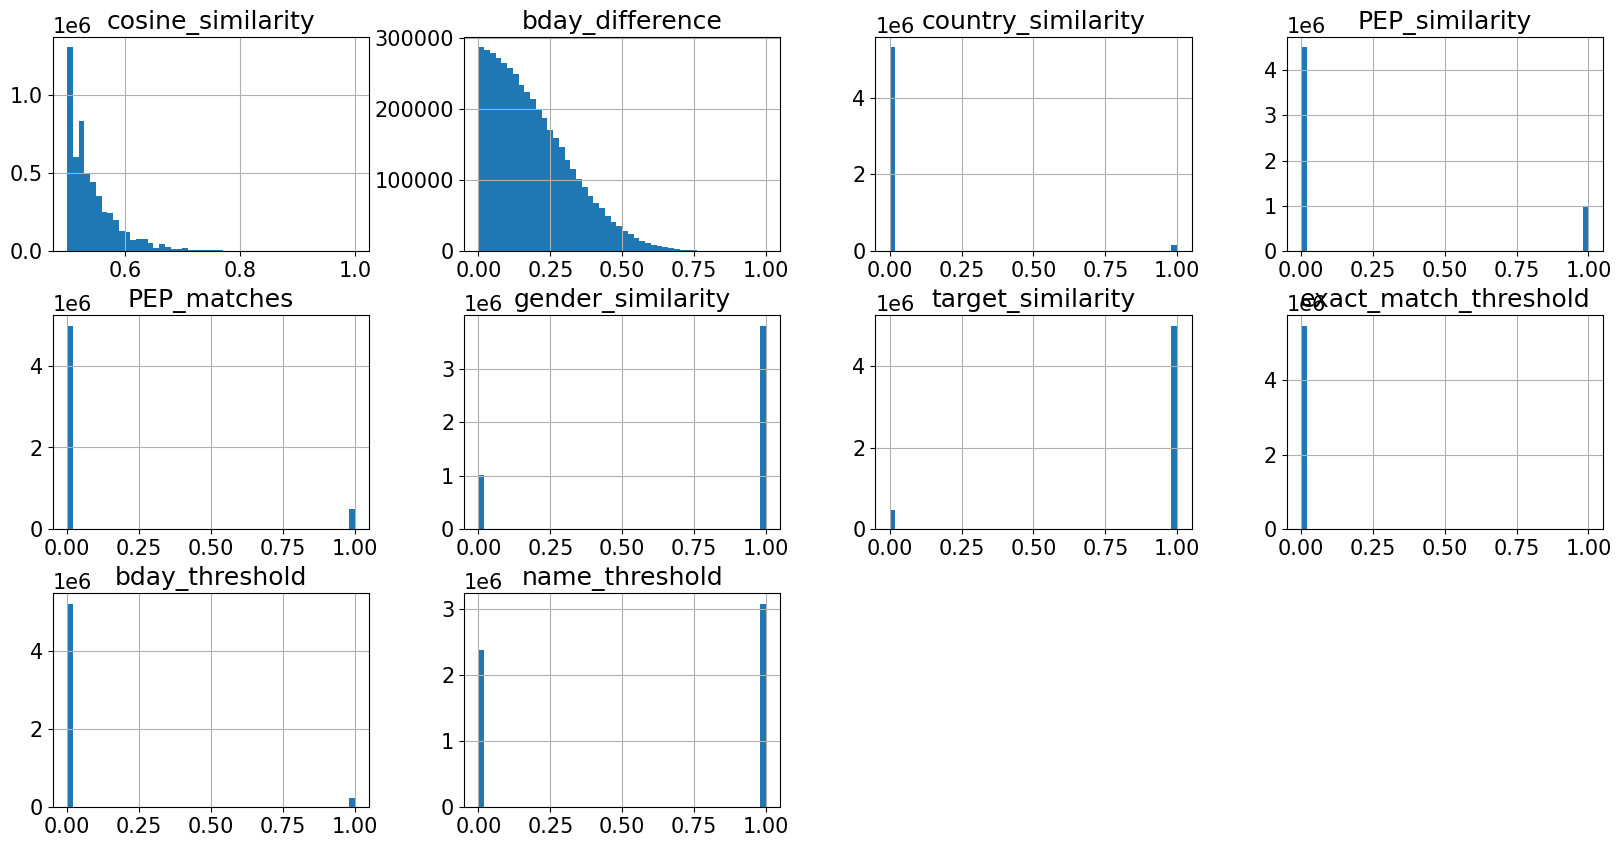

In [ ]:
matches_all_copy.hist(bins = 50, layout = (3, int(matches_all_copy.select_dtypes(np.number).shape[1] / 3) + 1), figsize= (20,10))
plt.show()

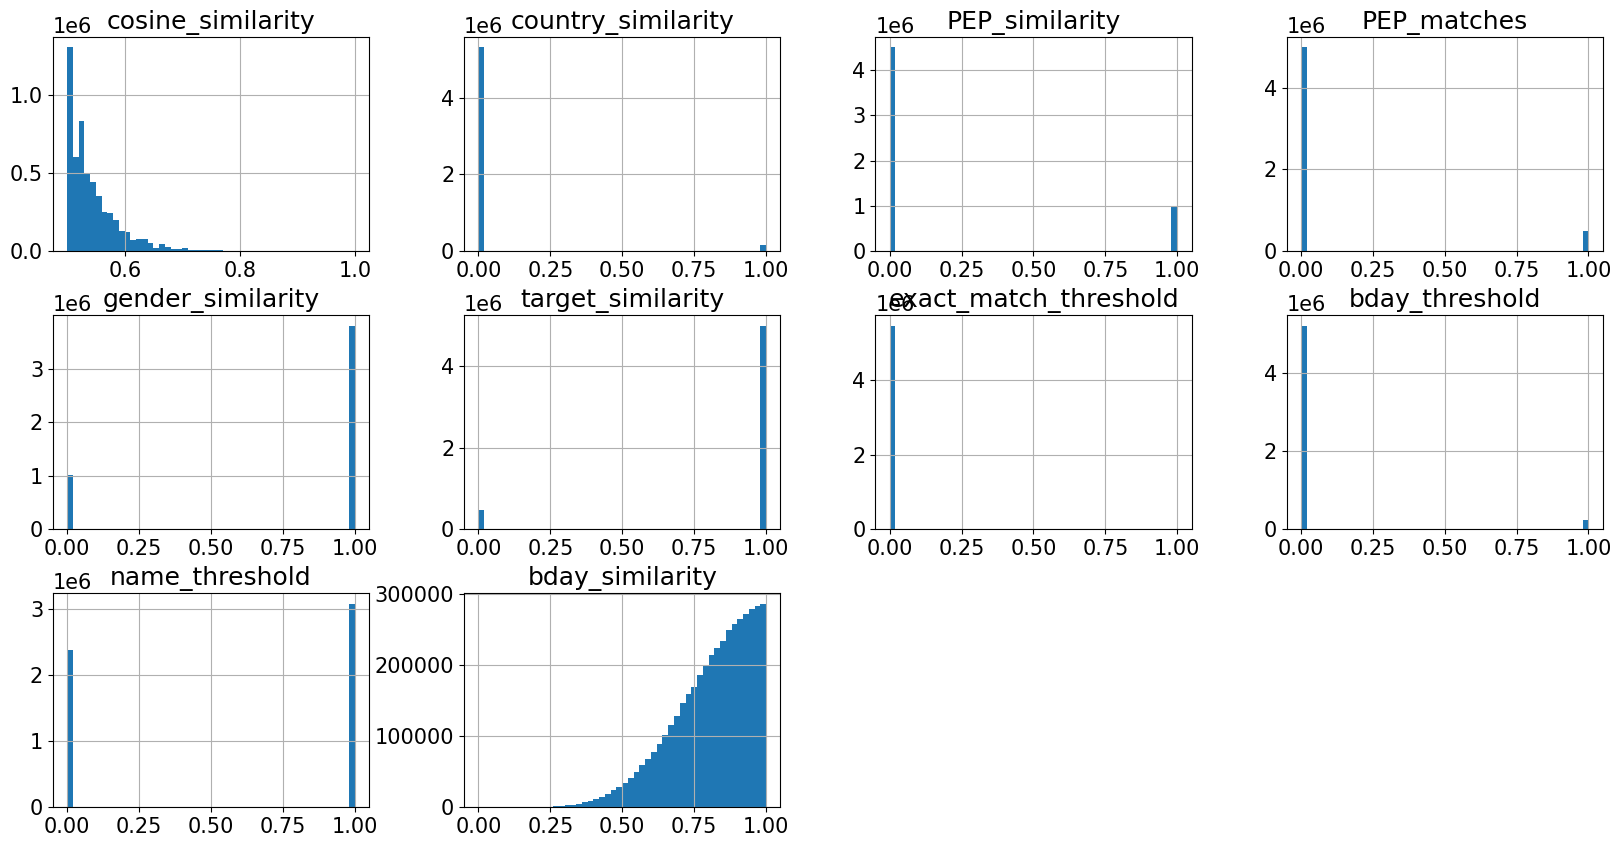

In [ ]:
# bday_difference to bday_similarity
matches_all_copy['bday_similarity'] = 1 - matches_all_copy['bday_difference']
matches_all_copy.drop(columns = ['bday_difference'], inplace=True)
matches_all_copy.hist(bins = 50, layout = (3, int(matches_all_copy.select_dtypes(np.number).shape[1] / 3) + 1), figsize= (20,10))
plt.show()

## avoid unintended consequence in reweighting if info is unavailable

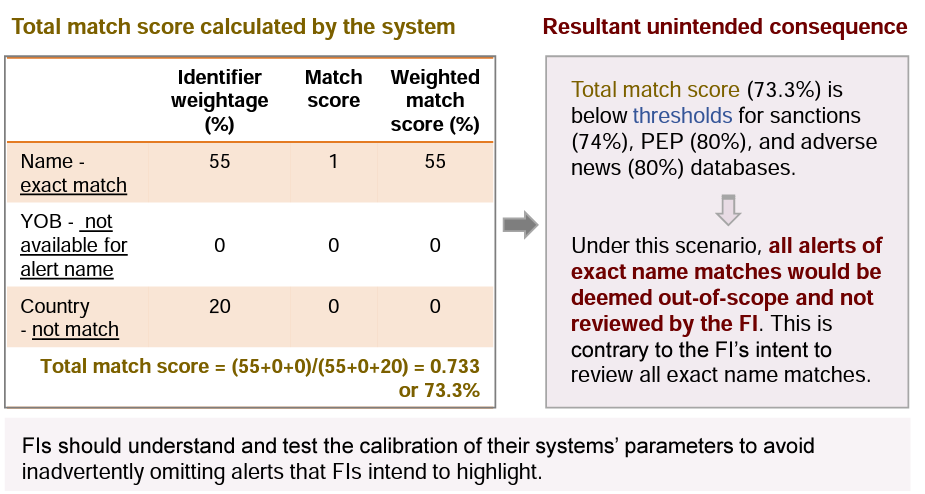

In [ ]:
# check NAN are still here for gender and bday
matches_all_copy.isna().sum().sort_values(ascending=False).to_frame().T

,bday_similarity,gender_similarity,customer_id,customer_side,target_id,target_side,cosine_similarity,country_similarity,PEP_similarity,PEP_matches,target_similarity,exact_match_threshold,bday_threshold,name_threshold
0,1141678,651620,0,0,0,0,0,0,0,0,0,0,0,0


## Sort by similarity scores
- further investigate these 50 players

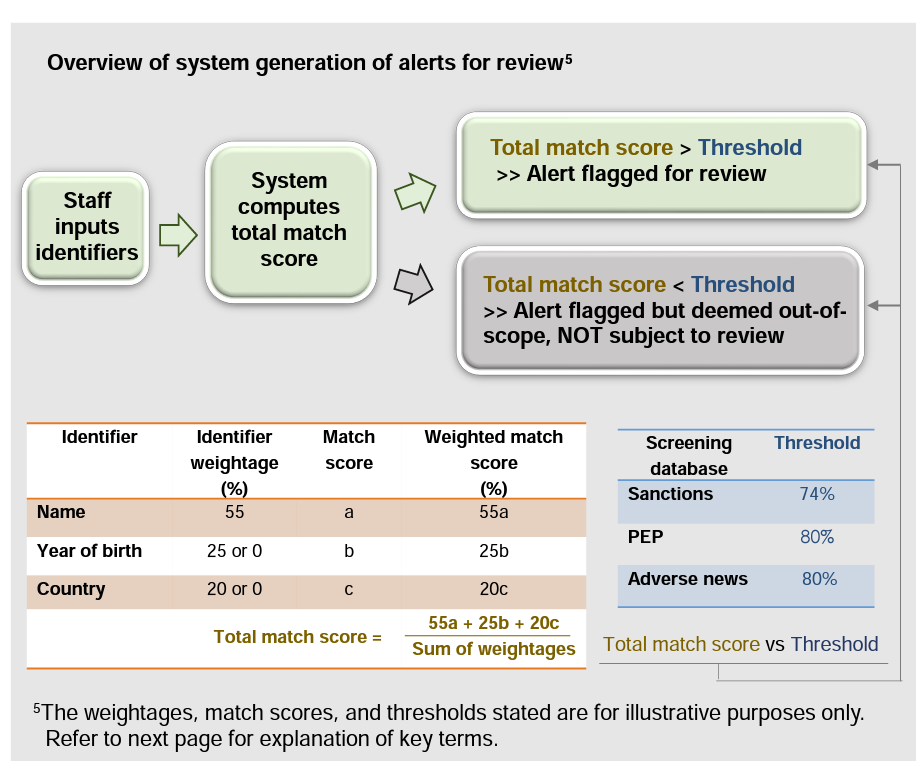

### sort in decreasing importance

In [ ]:
# decreasing subset with exact match
for col in sorted(matches_all_copy.select_dtypes(np.number).columns.values, key=lambda col: sum(matches_all_copy[col] == 1), reverse=True):
  print(f"{sum(matches_all_copy[col] >= 0.99):,.0f} {col}")

4,992,212 target_similarity
3,806,072 gender_similarity
3,084,430 name_threshold
969,642 PEP_similarity
484,049 PEP_matches
243,569 bday_threshold
160,577 country_similarity
2,376 exact_match_threshold
147,507 bday_similarity
2,679 cosine_similarity


In [ ]:
# sort by importance in decreasing order
sort_order = [
    'name_threshold', 'exact_match_threshold',  'gender_similarity', 'bday_threshold', 'PEP_similarity', 'cosine_similarity', 
    'target_similarity', 'PEP_matches', 'country_similarity', 'bday_similarity',
    ]

In [ ]:
sorted_matches = matches_all_copy.sort_values(
    sort_order, ascending=False)

# reorder columns
sorted_matches = sorted_matches[['customer_id', 'customer_side', 'target_id', 'target_side'] + sort_order]
sorted_matches


,customer_id,customer_side,target_id,target_side,name_threshold,exact_match_threshold,gender_similarity,bday_threshold,PEP_similarity,cosine_similarity,target_similarity,PEP_matches,country_similarity,bday_similarity
1101,178391,Paul Franklin Watson,Q201670,PAUL FRANKLIN WATSON,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000
1090,139717,Alexey Alexeyevich Gromov,Q4150188,Alexey Alexeyevich GROMOV,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000
1755,121103,Emilie Samra Konig,Q47221932,Emilie Samra Konig,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000
2678,853027,Tetiana Viktorivna Pereverzeva,NK-Z4xuBzHzmMEgDRcDYgExGc,Tetiana Viktorivna Pereverzeva,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000
2191,409822,Robert Acosta,Q16192660,Robert A. Costa,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.9924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5445943,122863,"alexander, Andrea",rupep-person-13420,Uporov Alexandr,0.0000,0.0000,NaN,0.0000,0.0000,0.5000,0.0000,0.0000,0.0000,NaN
5445946,122863,"alexander, Andrea",rupep-person-4655,Ershov Alexandr,0.0000,0.0000,NaN,0.0000,0.0000,0.5000,0.0000,0.0000,0.0000,NaN
5446436,365078,Alexandra DUOSE,rupep-person-13420,Uporov Alexandr,0.0000,0.0000,NaN,0.0000,0.0000,0.5000,0.0000,0.0000,0.0000,NaN
5446439,365078,Alexandra DUOSE,rupep-person-4655,Ershov Alexandr,0.0000,0.0000,NaN,0.0000,0.0000,0.5000,0.0000,0.0000,0.0000,NaN


In [ ]:
# output to csv
sorted_matches.reset_index(drop=True).to_pickle('matches_all_ranked.pkl')

## Output top 50 bad actors as np array

In [ ]:
matches_all_copy = pd.read_pickle('matches_all_ranked.pkl')
matches_all_copy.customer_id = matches_all_copy.customer_id.astype(str)

In [ ]:
# there can be multiple possible matches from different databases for the same customer_id
matches_all_copy.head(50)[matches_all_copy.head(50).duplicated(subset = ['customer_id'], keep = False)].sort_values('customer_id')

,customer_id,customer_side,target_id,target_side,name_threshold,exact_match_threshold,gender_similarity,bday_threshold,PEP_similarity,cosine_similarity,target_similarity,PEP_matches,country_similarity,bday_similarity
43,515322,David Jones Camp,Q728167,David Jones,1.0000,0.0000,1.0000,1.0000,1.0000,0.8165,1.0000,1.0000,0.0000,0.9852
44,515322,David Jones Camp,Q5236715,David Jones,1.0000,0.0000,1.0000,1.0000,1.0000,0.8165,1.0000,1.0000,0.0000,0.9840
30,618677,O Jong Gil,Q52159858,Jong Gil O,1.0000,0.0000,1.0000,1.0000,1.0000,0.8333,1.0000,0.0000,0.0000,1.0000
31,618677,O Jong Gil,Q52159858,JONG GIL O,1.0000,0.0000,1.0000,1.0000,1.0000,0.8333,1.0000,0.0000,0.0000,1.0000
37,894044,"Hlaing, Min Aung",Q3462649,Min Aung Hlaing,1.0000,0.0000,1.0000,1.0000,1.0000,0.8182,1.0000,0.0000,0.0000,1.0000
38,894044,"Hlaing, Min Aung",Q3462649,Min Aung HLAING,1.0000,0.0000,1.0000,1.0000,1.0000,0.8182,1.0000,0.0000,0.0000,1.0000
24,917730,Jose Benito Cabrera Cuevas,Q1709038,Jose Benito Cabrera,1.0000,0.0000,1.0000,1.0000,1.0000,0.8452,1.0000,0.0000,0.0000,1.0000
25,917730,Jose Benito Cabrera Cuevas,Q1709038,JOSE BENITO CABRERA,1.0000,0.0000,1.0000,1.0000,1.0000,0.8452,1.0000,0.0000,0.0000,1.0000


### drop multiple matches for same customer_id

In [ ]:
# need to drop duplicates
matches_all_copy = matches_all_copy.drop_duplicates(subset = ['customer_id']).reset_index(drop=True)
matches_all_copy

,customer_id,customer_side,target_id,target_side,name_threshold,exact_match_threshold,gender_similarity,bday_threshold,PEP_similarity,cosine_similarity,target_similarity,PEP_matches,country_similarity,bday_similarity
0,178391,Paul Franklin Watson,Q201670,PAUL FRANKLIN WATSON,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000
1,139717,Alexey Alexeyevich Gromov,Q4150188,Alexey Alexeyevich GROMOV,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000
2,121103,Emilie Samra Konig,Q47221932,Emilie Samra Konig,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000
3,853027,Tetiana Viktorivna Pereverzeva,NK-Z4xuBzHzmMEgDRcDYgExGc,Tetiana Viktorivna Pereverzeva,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000
4,409822,Robert Acosta,Q16192660,Robert A. Costa,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.9924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505087,825810,Neil Henrickson,us-cia-luxembourg-henri-grand-duke,HENRI,0.0000,0.0000,NaN,0.0000,0.0000,0.5000,1.0000,0.0000,0.0000,NaN
505088,10630,Juan Shamapande,Q59627580,Shama,0.0000,0.0000,NaN,0.0000,0.0000,0.5000,1.0000,0.0000,0.0000,NaN
505089,903239,"Svobodny, Barbara",Q59222535,Barba,0.0000,0.0000,NaN,0.0000,0.0000,0.5000,1.0000,0.0000,0.0000,NaN
505090,374789,"Spurlock, Barbara",Q59222535,Barba,0.0000,0.0000,NaN,0.0000,0.0000,0.5000,1.0000,0.0000,0.0000,NaN


### top 50 bad actors

In [ ]:
matches_all_copy.head(50)

,customer_id,customer_side,target_id,target_side,name_threshold,exact_match_threshold,gender_similarity,bday_threshold,PEP_similarity,cosine_similarity,target_similarity,PEP_matches,country_similarity,bday_similarity
0,178391,Paul Franklin Watson,Q201670,PAUL FRANKLIN WATSON,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000
1,139717,Alexey Alexeyevich Gromov,Q4150188,Alexey Alexeyevich GROMOV,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000
2,121103,Emilie Samra Konig,Q47221932,Emilie Samra Konig,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000
3,853027,Tetiana Viktorivna Pereverzeva,NK-Z4xuBzHzmMEgDRcDYgExGc,Tetiana Viktorivna Pereverzeva,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000
4,409822,Robert Acosta,Q16192660,Robert A. Costa,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.9924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,657830,"Gibson, Connie Lawson",Q5161888,Connie Lawson,1.0000,0.0000,1.0000,1.0000,1.0000,0.8165,1.0000,1.0000,0.0000,0.9969
46,977728,"Philo, Stephen Smith",Q107369535,Stephen Smith,1.0000,0.0000,1.0000,1.0000,1.0000,0.8165,1.0000,1.0000,0.0000,0.9958
47,804629,"Martin, Joseph",Q15126384,Martin Joseph Walsh,1.0000,0.0000,1.0000,1.0000,1.0000,0.8165,1.0000,1.0000,0.0000,0.9910
48,918145,"Tyler, Patrick Brown",Q3369936,Patrick Brown,1.0000,0.0000,1.0000,1.0000,1.0000,0.8165,1.0000,1.0000,0.0000,0.9896


#### check if which of 50 bad actors are not in graph

In [ ]:
edges = pd.read_csv('../UofT_edges.csv')
# Ensure the sum of weights for all outgoing links from a node is 1
edges_weighted = edges.copy(deep = True)
edges_weighted['source'] = edges_weighted['source'].astype(int).astype(str)
edges_weighted['target'] = edges_weighted['target'].astype(int).astype(str)
edges_weighted['weight'] = edges_weighted['emt'] / edges_weighted.groupby('source')['emt'].transform('sum')
# created a edgelist and loaded
import networkx as nx
# https://networkx.org/documentation/stable//reference/generated/networkx.convert_matrix.from_pandas_edgelist.html#networkx.convert_matrix.from_pandas_edgelist
G = nx.from_pandas_edgelist(
    edges_weighted, 
    "source", "target", 
    create_using=nx.DiGraph(), # directed graph with self loops
    edge_attr="weight") # edge weights

In [ ]:
# top 50 bad actors who are not in UofT_edges
# matches still make sense so let's keep them
matches_all_copy.head(50)[~matches_all_copy.head(50).customer_id.isin(G.nodes)]

,customer_id,customer_side,target_id,target_side,name_threshold,exact_match_threshold,gender_similarity,bday_threshold,PEP_similarity,cosine_similarity,target_similarity,PEP_matches,country_similarity,bday_similarity
4,409822,Robert Acosta,Q16192660,Robert A. Costa,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.9924
5,794941,Peter Watkins,Q369627,Peter W. Atkins,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.9946
6,530296,Eric Stewart,Q5387573,Eric Stewart,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.7371
7,209446,Ma rk King,Q25354502,Mark King,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.4116
9,192721,James Thomas Bailey,Q94552393,James Thomas Bailey,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.7505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,268567,"Craft, Linda Johnson",Q6551688,Linda Johnson,1.0000,0.0000,1.0000,1.0000,1.0000,0.8165,1.0000,1.0000,1.0000,0.9966
44,654805,Donald Thomas,Q28968013,Donald Thomas Punch,1.0000,0.0000,1.0000,1.0000,1.0000,0.8165,1.0000,1.0000,0.0000,0.9976
45,657830,"Gibson, Connie Lawson",Q5161888,Connie Lawson,1.0000,0.0000,1.0000,1.0000,1.0000,0.8165,1.0000,1.0000,0.0000,0.9969
46,977728,"Philo, Stephen Smith",Q107369535,Stephen Smith,1.0000,0.0000,1.0000,1.0000,1.0000,0.8165,1.0000,1.0000,0.0000,0.9958


In [ ]:
# output as npy array
top_50_bad_actors = matches_all_copy.head(50).customer_id.values.astype(str)
np.save('top_50_bad_actors_customer_id', top_50_bad_actors)
np.load('top_50_bad_actors_customer_id.npy')

array(['178391', '139717', '121103', '853027', '409822', '794941',
       '530296', '209446', '489249', '192721', '199900', '752207',
       '763368', '995243', '479020', '309688', '222543', '828839',
       '123335', '376264', '592809', '859785', '477073', '835615',
       '917730', '314383', '276068', '616682', '248220', '618677',
       '187299', '480621', '935713', '239762', '262860', '894044',
       '629144', '89533', '93991', '517500', '515322', '531862', '627183',
       '268567', '654805', '657830', '977728', '804629', '918145',
       '356859'], dtype='<U6')

## *Only match on high risk customers
- currently only rank by similarity
- If we want to catch bad actors, we should match on only RISK = high in nodes_df

In [ ]:
# RISK == 'high'
matches_all_test = matches_all_copy.\
merge(nodes_df[['CUSTOMER_ID', 'BIRTH_DT', 'RISK', 'PEP_FL', 'GENDER']], left_on = 'customer_id', right_on = 'CUSTOMER_ID', how = 'left').\
merge(person_detailed[['id', 'birthDate', 'datasets', 'gender']], left_on = ['target_id'], right_on = ['id'], how = 'left')

matches_all_high_risk = matches_all_test[matches_all_test.RISK == 'high'].reset_index(drop=True)
matches_all_high_risk.head(50)

,customer_id,customer_side,target_id,target_side,name_threshold,exact_match_threshold,gender_similarity,bday_threshold,PEP_similarity,cosine_similarity,target_similarity,PEP_matches,country_similarity,bday_similarity,CUSTOMER_ID,BIRTH_DT,RISK,PEP_FL,GENDER,id,birthDate,datasets,gender
0,178391,Paul Franklin Watson,Q201670,PAUL FRANKLIN WATSON,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000,178391,1950-12-02,high,0.0000,Male,Q201670,1950-12-02,interpol_red_notices,male
1,139717,Alexey Alexeyevich Gromov,Q4150188,Alexey Alexeyevich GROMOV,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,139717,1960-05-31,high,0.0000,Male,Q4150188,1960-05-31,be_fod_sanctions,male
2,121103,Emilie Samra Konig,Q47221932,Emilie Samra Konig,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,121103,1984-12-09,high,0.0000,Female,Q47221932,1984-12-09,il_mod_terrorists,female
3,853027,Tetiana Viktorivna Pereverzeva,NK-Z4xuBzHzmMEgDRcDYgExGc,Tetiana Viktorivna Pereverzeva,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,853027,1964-06-20,high,0.0000,Female,NK-Z4xuBzHzmMEgDRcDYgExGc,1964-06-20,be_fod_sanctions,female
4,199900,"Basova, Lidiya Oleksandrivna",NK-7dwYVASfwQMKGmJBWWEVYt,Lidiya Oleksandrivna Basova,1.0000,0.0000,1.0000,1.0000,1.0000,0.9130,1.0000,0.0000,0.0000,1.0000,199900,1972-01-01,high,0.0000,Female,NK-7dwYVASfwQMKGmJBWWEVYt,1972,be_fod_sanctions,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,82855,Charles Channel Clark,Q333758,Charles Clarke,1.0000,0.0000,1.0000,1.0000,1.0000,0.6784,1.0000,1.0000,0.0000,0.9894,82855,1951-12-23,high,1.0000,Male,Q333758,1950-09-21,everypolitician,male
46,179288,"Hughes, Mark Williams",Q105188169,William Hughes,1.0000,0.0000,1.0000,1.0000,1.0000,0.6784,1.0000,1.0000,0.0000,0.9840,179288,1963-01-04,high,1.0000,Male,Q105188169,1964-11-26,wikidata,male
47,495319,Michael Sabo Jones,Q102122976,Michael Jones,1.0000,0.0000,1.0000,1.0000,1.0000,0.6761,1.0000,1.0000,0.0000,0.9893,495319,1971-06-27,high,1.0000,Male,Q102122976,1970-03-23,wikidata,male
48,51394,William Edward Watt,Q5336528,William Edward TEARE MHK,1.0000,0.0000,1.0000,1.0000,1.0000,0.6745,1.0000,1.0000,0.0000,0.9937,51394,1949-02-04,high,1.0000,Male,Q5336528,1948-05-10,everypolitician,male


In [ ]:
# top 50 bad actors who are not in UofT_edges
# matches still make sense so let's keep them
matches_all_high_risk.head(50)[~matches_all_high_risk.head(50).customer_id.isin(G.nodes)]

,customer_id,customer_side,target_id,target_side,name_threshold,exact_match_threshold,gender_similarity,bday_threshold,PEP_similarity,cosine_similarity,target_similarity,PEP_matches,country_similarity,bday_similarity,CUSTOMER_ID,BIRTH_DT,RISK,PEP_FL,GENDER,id,birthDate,datasets,gender
29,633939,"Wood, Patrick N'elson",Q16745433,Rick Nelson,1.0000,0.0000,1.0000,1.0000,1.0000,0.7303,1.0000,1.0000,0.0000,0.9898,633939,1953-03-29,high,1.0000,Male,Q16745433,1954-06-11,wikidata,male
34,433,Francis Combs LINDA#L,Q63763283,Francis Comby,1.0000,0.0000,1.0000,1.0000,1.0000,0.7115,1.0000,1.0000,0.0000,0.9950,433,1961-03-06,high,1.0000,Male,Q63763283,1961-10-09,wikidata,male
47,495319,Michael Sabo Jones,Q102122976,Michael Jones,1.0000,0.0000,1.0000,1.0000,1.0000,0.6761,1.0000,1.0000,0.0000,0.9893,495319,1971-06-27,high,1.0000,Male,Q102122976,1970-03-23,wikidata,male


In [ ]:
matches_all_high_risk[matches_all_high_risk.customer_id.isin(['584841', '376264'])]

,customer_id,customer_side,target_id,target_side,name_threshold,exact_match_threshold,gender_similarity,bday_threshold,PEP_similarity,cosine_similarity,target_similarity,PEP_matches,country_similarity,bday_similarity,CUSTOMER_ID,BIRTH_DT,RISK,PEP_FL,GENDER,id,birthDate,datasets,gender
8,376264,"Oleksin, Alexei Ivanovich",Q64438502,OLEKSIN Aleksei Ivanovich,1.0000,0.0000,1.0000,1.0000,1.0000,0.8721,1.0000,0.0000,0.0000,1.0000,376264,1966-10-29,high,0.0000,Male,Q64438502,1966-10-29,be_fod_sanctions,male
19,584841,"Al-Zawahiri, Aiman Muhammad Rabi",Q186316,Aiman Muhammed Rabi AL-ZAWAHIRI,1.0000,0.0000,1.0000,1.0000,1.0000,0.8000,1.0000,0.0000,0.0000,0.9998,584841,1951-06-19,high,0.0000,Male,Q186316,1951-06-09,il_mod_terrorists,male


In [ ]:
matches_all_high_risk[matches_all_high_risk.customer_id.isin(['824820'])]

,customer_id,customer_side,target_id,target_side,name_threshold,exact_match_threshold,gender_similarity,bday_threshold,PEP_similarity,cosine_similarity,target_similarity,PEP_matches,country_similarity,bday_similarity,CUSTOMER_ID,BIRTH_DT,RISK,PEP_FL,GENDER,id,birthDate,datasets,gender
94,824820,Andrew Rogers Fisher,Q105188045,Andrew Fisher,1.0000,0.0000,1.0000,1.0000,1.0000,0.6325,1.0000,1.0000,0.0000,0.9843,824820,1953-12-15,high,1.0000,Male,Q105188045,1955-10-23,wikidata,male


In [ ]:
matches_all_high_risk[matches_all_high_risk.customer_id.isin(['288061'])]

,customer_id,customer_side,target_id,target_side,name_threshold,exact_match_threshold,gender_similarity,bday_threshold,PEP_similarity,cosine_similarity,target_similarity,PEP_matches,country_similarity,bday_similarity,CUSTOMER_ID,BIRTH_DT,RISK,PEP_FL,GENDER,id,birthDate,datasets,gender
25,288061,"Tsertsel, Ivan Stanislavavich",Q96435835,Ivan Stanislavavich TERTEL,1.0000,0.0000,1.0000,1.0000,1.0000,0.7557,1.0000,0.0000,0.0000,1.0000,288061,1966-09-08,high,0.0000,Male,Q96435835,1966-09-08,be_fod_sanctions,male


In [ ]:
# output as npy array
matches_all_high_risk.head(50).to_csv('matches_all_high_risk.csv', index = False)
top_50_bad_actors_high_risk = matches_all_high_risk.head(50).customer_id.values.astype(str)
np.save('top_50_bad_actors_customer_id_high_risk', top_50_bad_actors_high_risk)
np.load('top_50_bad_actors_customer_id_high_risk.npy')

array(['178391', '139717', '121103', '853027', '199900', '752207',
       '763368', '479020', '376264', '592809', '917730', '616682',
       '618677', '894044', '412911', '557416', '479267', '227988',
       '929576', '584841', '546804', '734822', '255636', '275053',
       '758071', '288061', '382314', '883073', '948991', '633939',
       '284176', '289684', '112127', '40939', '433', '888132', '680217',
       '940843', '16499', '305654', '115353', '849608', '708895',
       '661741', '87457', '82855', '179288', '495319', '51394', '273449'],
      dtype='<U6')

## Visualization

In [ ]:
matches_all_high_risk.columns

Index(['customer_id', 'customer_side', 'target_id', 'target_side',
       'name_threshold', 'exact_match_threshold', 'gender_similarity',
       'bday_threshold', 'PEP_similarity', 'cosine_similarity',
       'target_similarity', 'PEP_matches', 'country_similarity',
       'bday_similarity', 'CUSTOMER_ID', 'BIRTH_DT', 'RISK', 'PEP_FL',
       'GENDER', 'id', 'birthDate', 'datasets', 'gender'],
      dtype='object')

In [ ]:
matches_all_high_risk_viz = pd.concat([matches_all_high_risk.head(15)], axis = 0).\
reindex(columns = [
    'customer_side', 'GENDER', 'BIRTH_DT', 
    'target_side', 'gender', 'birthDate', 
    # 'exact_match_threshold', 'gender_similarity', 'bday_threshold', 'PEP_similarity', 
    'cosine_similarity', 
    # 'target_similarity', 'country_similarity',
    ]).\
rename(columns = {
    'customer_side': 'Scotiabank customers', 
    'target_side': 'OpenSanctions targets',
    'BIRTH_DT': 'DOB1',
    'birthDate': 'DOB2',
    'GENDER': 'GENDER1',
    'gender': 'GENDER2',
    # 'exact_match_threshold': 'Exact match?',
    # 'gender_similarity': 'Same gender?',
    # 'bday_threshold': 'DOB <= 2y?',
    # 'PEP_similarity': 'Same PEP?',
    'cosine_similarity': 'Cosine Similarity',
    # 'target_similarity': 'Target?',
    # 'country_similarity': 'Same country?'
    })

def gender_condition(v):
    return v.title()

matches_all_high_risk_viz.\
style.\
format('{:.4f}', subset = matches_all_high_risk_viz.select_dtypes(np.number).columns).\
set_table_styles([
    {'selector': '*', 'props': 'padding: 2px 5px; min-height: 5px; min-width: 80px; max-width: 80px; font-size: 10pt; text-align: center'},
], overwrite=False).\
background_gradient(cmap = 'Reds', subset =['Cosine Similarity'], vmin = 0.75, vmax = 1).\
set_properties(**{'background-color': 'white', 'color': 'black', 'border-color': 'white', 'min-width': '270px', 'text-align': 'left'}, subset = ['Scotiabank customers', 'OpenSanctions targets']).\
set_table_styles({
    ('Scotiabank customers'): [{'selector': 'th', 'props': 'font-weight: bold;background-color: red;color: white; text-align: left'}],
    ('DOB1'): [{'selector': 'th', 'props': 'font-weight: bold;background-color: red;color: white; text-align: center'}],
    ('GENDER1'): [{'selector': 'th', 'props': 'font-weight: bold;background-color: red;color: white; text-align: center'}],
    ('OpenSanctions targets'): [{'selector': 'th', 'props': 'background-color: #3981F6;font-weight: bold;color: white; text-align: left'}],
    ('DOB2'): [{'selector': 'th', 'props': 'font-weight: bold;background-color: #3981F6;color: white; text-align: center'}],
    ('GENDER2'): [{'selector': 'th', 'props': 'font-weight: bold;background-color: #3981F6;color: white; text-align: center'}],
    ('Cosine Similarity'): [{'selector': 'th', 'props': 'font-weight: bold;background-color: #333333;color:white; text-align: center'},
                            {'selector': 'td', 'props': 'font-weight: bold;color:white; text-align: center'}],
}, overwrite=False, axis=0).\
format(gender_condition, subset = ['GENDER2'])

# set_table_styles({
#     (6): [{'selector': 'th', 'props': 'border-bottom: 1px solid #000066;'},
#           {'selector': 'td', 'props': 'border-bottom: 1px solid #000066;'}],
# }, overwrite=False, axis=1).\

,Scotiabank customers,GENDER1,DOB1,OpenSanctions targets,GENDER2,DOB2,Cosine Similarity
0,Paul Franklin Watson,Male,1950-12-02,PAUL FRANKLIN WATSON,Male,1950-12-02,1.0000
1,Alexey Alexeyevich Gromov,Male,1960-05-31,Alexey Alexeyevich GROMOV,Male,1960-05-31,1.0000
2,Emilie Samra Konig,Female,1984-12-09,Emilie Samra Konig,Female,1984-12-09,1.0000
3,Tetiana Viktorivna Pereverzeva,Female,1964-06-20,Tetiana Viktorivna Pereverzeva,Female,1964-06-20,1.0000
4,"Basova, Lidiya Oleksandrivna",Female,1972-01-01,Lidiya Oleksandrivna Basova,Female,1972,0.9130
5,"Bezrukov, Sergey Vitalyevich",Male,1973-10-18,Sergey Vitalyevich BEZRUKOV,Male,1973-10-18,0.9130
6,"Zheynova, Marina Nikolaevna",Female,1985-02-15,Marina Nikolaevna ZHEYNOVA,Female,1985-02-15,0.9091
7,Rakhim Azizboevich Azimov,Male,1964-08-16,AZIMOV Rakhim Azizboevich,Male,1964-08-16,0.9000
8,"Oleksin, Alexei Ivanovich",Male,1966-10-29,OLEKSIN Aleksei Ivanovich,Male,1966-10-29,0.8721
9,Herlinto Chamorro Acosta,Male,1956-01-10,ELIECER HERLINTO CHAMORRO ACOSTA,Male,1956-01-10,0.8607


# Issues to avoid

## exclude these words

Monetary Authority of Singapore AML Name Screening https://www.mas.gov.sg/-/media/MAS-Media-Library/publications/monographs-or-information-paper/IMD/2022/Strengthening-AML-CFT-Name-Screening-Practices.pdf

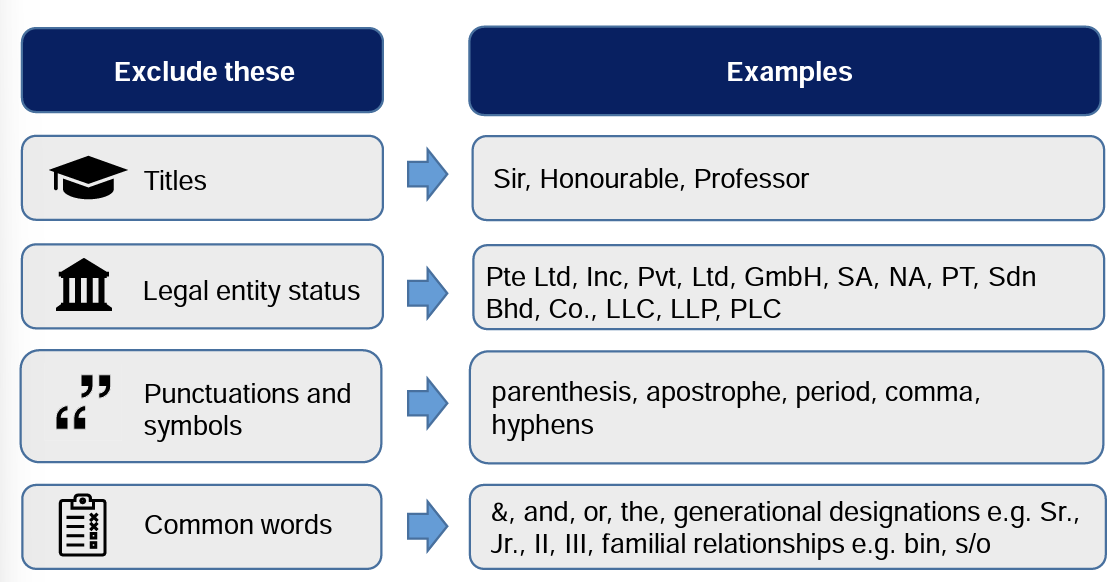

## use pairs.json to improve accuracy
https://www.opensanctions.org/docs/pairs/ 

## Have those targets died already?

# Reference: SG MAS name screening best practices

https://www.mas.gov.sg/-/media/MAS-Media-Library/publications/monographs-or-information-paper/IMD/2022/Strengthening-AML-CFT-Name-Screening-Practices.pdf

## Alternative: Targets open sanctions
- instead of entities.ftm (each row is an entity, easier for search)

In [ ]:
# targets_df = pd.read_json('targets.nested.json', lines=True, nrows = 232984)
# targets_df

In [ ]:
# pd.json_normalize(targets_df[targets_df['schema'] == 'Person'].properties)